# Stroke Prediction (Tabular)

 (Install → Imports → Load → Clean → Split → Preprocess → Helpers → Train/Eval → Plots).


## (1) — Install

In [28]:
!pip -q install --no-cache-dir pytorch-tabnet catboost xgboost imbalanced-learn


## الخلية (2) — Imports + Seed

In [29]:
import os, time, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, balanced_accuracy_score,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from catboost import CatBoostClassifier
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)


## الخلية (3) — Load CSV من Drive

In [30]:
from google.colab import drive
drive.mount('/content/drive')

target_name = "stroke_risk_dataset (1).csv"
root = "/content/drive/MyDrive"

found_paths = []
for dirpath, dirnames, filenames in os.walk(root):
    if target_name in filenames:
        found_paths.append(os.path.join(dirpath, target_name))

if not found_paths:
    raise FileNotFoundError(f"لم أجد الملف داخل {root} بالاسم: {target_name}")

csv_path = found_paths[0]
print("Found:", csv_path)

Data = pd.read_csv(csv_path)
print("Loaded shape:", Data.shape)
display(Data.head())

print("\nMissing values per column:\n", Data.isna().sum().sort_values(ascending=False).head(20))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found: /content/drive/MyDrive/stroke_risk_dataset (1).csv
Loaded shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Missing values per column:
 bmi                  201
id                     0
age                    0
gender                 0
hypertension           0
heart_disease          0
work_type              0
ever_married           0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64


##الخلية (4) — Minimal cleaning (NO leakage)

In [31]:
df = Data.copy()

if "id" in df.columns:
    df = df.drop(columns=["id"])

if "gender" in df.columns:
    df = df[df["gender"].astype(str).str.lower() != "other"].copy()

assert "stroke" in df.columns, "Target column 'stroke' not found!"

print("After cleaning:", df.shape)
display(df.head())


After cleaning: (5109, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##الخلية (5) — Feature add-ons  — add right after minimal cleaning
 Adds:
   1) bmi_missing  -> preserves missingness signal
   2) log_glucose  -> stabilizes skew in avg_glucose_level (if present)


In [37]:


import numpy as np

df = df.copy()

# 1) Missing indicator for BMI (very important on this dataset)
if "bmi" in df.columns:
    df["bmi_missing"] = df["bmi"].isna().astype(int)
else:
    df["bmi_missing"] = 0  # safe fallback

# 2) Log transform for glucose (optional but usually helps linear/gb models)
if "avg_glucose_level" in df.columns:
    g = pd.to_numeric(df["avg_glucose_level"], errors="coerce")
    df["log_glucose"] = np.log1p(g.clip(lower=0))
else:
    df["log_glucose"] = 0.0  # safe fallback

print("✅ Added columns:", [c for c in ["bmi_missing","log_glucose"] if c in df.columns])
display(df[["bmi","bmi_missing","avg_glucose_level","log_glucose"]].head(10))


✅ Added columns: ['bmi_missing', 'log_glucose']


,bmi,bmi_missing,avg_glucose_level,log_glucose
0,36.6,0,228.69,5.436731
1,NaN,1,202.21,5.314240
2,32.5,0,105.92,4.672081
3,34.4,0,171.23,5.148831
4,24.0,0,174.12,5.165471
5,29.0,0,186.21,5.232231
6,27.4,0,70.09,4.263947
7,22.8,0,94.39,4.557974
8,NaN,1,76.15,4.345752
9,24.2,0,58.57,4.087152


## الخلية (6) — Train/Val/Test split stratified

In [38]:
X = df.drop(columns=["stroke"])
y = df["stroke"].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=SEED, stratify=y_temp
)

print("Train:", X_train.shape, "Pos rate:", y_train.mean())
print("Val  :", X_val.shape,   "Pos rate:", y_val.mean())
print("Test :", X_test.shape,  "Pos rate:", y_test.mean())


Train: (3575, 12) Pos rate: 0.04895104895104895
Val  : (767, 12) Pos rate: 0.048239895697522815
Test : (767, 12) Pos rate: 0.048239895697522815


## الخلية (7) — Preprocess (fit على TRAIN فقط)

In [41]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_train.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'bmi_missing', 'log_glucose']
Categorical: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


## الخلية (8) — Helpers

In [42]:
def _as_np(y):
    if isinstance(y, (pd.Series, pd.DataFrame)):
        return y.values.ravel()
    return np.asarray(y).ravel()

def pick_best_threshold_f1(y_true, proba):
    y_true = _as_np(y_true).astype(int)
    proba = np.asarray(proba).ravel()
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    f1_thr = f1[1:]
    best_i = int(np.nanargmax(f1_thr))
    return float(thr[best_i]), float(f1_thr[best_i])

def evaluate_at_thr(y_true, proba, thr):
    y_true = _as_np(y_true).astype(int)
    proba = np.asarray(proba).ravel()
    pred = (proba >= thr).astype(int)

    cm = confusion_matrix(y_true, pred)
    tn, fp, fn, tp = cm.ravel()

    precision_pos = tp / (tp + fp + 1e-12)
    recall_pos    = tp / (tp + fn + 1e-12)
    f1_pos        = 2 * precision_pos * recall_pos / (precision_pos + recall_pos + 1e-12)

    acc = (tp + tn) / (tp + tn + fp + fn + 1e-12)
    bal_acc = balanced_accuracy_score(y_true, pred)

    roc = roc_auc_score(y_true, proba) if len(np.unique(y_true)) == 2 else np.nan
    pr  = average_precision_score(y_true, proba) if len(np.unique(y_true)) == 2 else np.nan

    return {
        "thr": float(thr),
        "accuracy": float(acc),
        "balanced_acc": float(bal_acc),
        "precision_pos": float(precision_pos),
        "recall_pos": float(recall_pos),
        "f1_pos": float(f1_pos),
        "roc_auc": float(roc),
        "pr_auc": float(pr),
        "cm": cm
    }

def plot_curves_all(curves, order, title_suffix="(TEST)"):
    plt.figure(figsize=(7,5))
    for name in order:
        c = curves[name]
        plt.plot(c["fpr"], c["tpr"], label=name)
    plt.plot([0,1],[0,1],"--")
    plt.title(f"ROC Curves {title_suffix}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,5))
    for name in order:
        c = curves[name]
        plt.plot(c["r"], c["p"], label=name)
    plt.title(f"Precision-Recall Curves {title_suffix}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()


##الخلية (9) — Train + VAL threshold + TEST eval (LogReg/HistGB/CatBoost/TabNet)

In [43]:
preprocess.fit(X_train, y_train)

def transform_any(Xdf):
    Z = preprocess.transform(Xdf)
    try:
        Z = Z.toarray()
    except Exception:
        pass
    return np.asarray(Z)

Xtr = transform_any(X_train)
Xva = transform_any(X_val)
Xte = transform_any(X_test)

Xtr_f = Xtr.astype(np.float32)
Xva_f = Xva.astype(np.float32)
Xte_f = Xte.astype(np.float32)

y_train_np = _as_np(y_train).astype(int)
y_val_np   = _as_np(y_val).astype(int)
y_test_np  = _as_np(y_test).astype(int)

print(f"Train pos={(y_train_np==1).sum()}, neg={(y_train_np==0).sum()}")

models = {}

models["LogReg"] = LogisticRegression(
    max_iter=8000,
    class_weight="balanced",
    solver="liblinear",
    random_state=SEED
)

models["HistGB"] = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=4,
    max_iter=900,
    l2_regularization=0.2,
    min_samples_leaf=20,
    early_stopping=False,
    random_state=SEED
)

cat_cols_native = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols_native]

models["CatBoost"] = CatBoostClassifier(
    iterations=8000,
    learning_rate=0.03,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=SEED,
    auto_class_weights="Balanced",
    od_type="Iter",
    od_wait=300,
    verbose=400,
    allow_writing_files=False
)

models["TabNet"] = TabNetClassifier(
    n_d=32, n_a=32, n_steps=6,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=25, gamma=0.7),
    mask_type="entmax",
    seed=SEED,
    verbose=10
)

results = []
probas_test = {}
curves = {}

def _store_curves(name, y_true, proba):
    fpr, tpr, _ = roc_curve(y_true, proba)
    p, r, _ = precision_recall_curve(y_true, proba)
    curves[name] = {"fpr": fpr, "tpr": tpr, "p": p, "r": r}

for name in ["LogReg", "HistGB"]:
    clf = models[name]
    clf.fit(Xtr, y_train_np)

    val_proba = clf.predict_proba(Xva)[:, 1]
    thr, val_best_f1 = pick_best_threshold_f1(y_val_np, val_proba)

    test_proba = clf.predict_proba(Xte)[:, 1]
    met = evaluate_at_thr(y_test_np, test_proba, thr)
    met.update({"model": name, "val_best_f1": float(val_best_f1)})
    results.append(met)

    probas_test[name] = test_proba
    _store_curves(name, y_test_np, test_proba)

cb = models["CatBoost"]
cb.fit(
    X_train, y_train_np,
    eval_set=(X_val, y_val_np),
    cat_features=cat_idx,
    use_best_model=True
)

val_proba = cb.predict_proba(X_val)[:, 1]
thr, val_best_f1 = pick_best_threshold_f1(y_val_np, val_proba)

test_proba = cb.predict_proba(X_test)[:, 1]
met = evaluate_at_thr(y_test_np, test_proba, thr)
met.update({"model": "CatBoost", "val_best_f1": float(val_best_f1)})
results.append(met)

probas_test["CatBoost"] = test_proba
_store_curves("CatBoost", y_test_np, test_proba)

tabnet = models["TabNet"]
tabnet.fit(
    Xtr_f, y_train_np,
    eval_set=[(Xva_f, y_val_np)],
    eval_metric=["auc"],
    max_epochs=220,
    patience=35,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    weights=1
)

val_proba = tabnet.predict_proba(Xva_f)[:, 1]
thr, val_best_f1 = pick_best_threshold_f1(y_val_np, val_proba)

test_proba = tabnet.predict_proba(Xte_f)[:, 1]
met = evaluate_at_thr(y_test_np, test_proba, thr)
met.update({"model": "TabNet", "val_best_f1": float(val_best_f1)})
results.append(met)

probas_test["TabNet"] = test_proba
_store_curves("TabNet", y_test_np, test_proba)

results_df = pd.DataFrame([{k:v for k,v in r.items() if k!="cm"} for r in results]) \
    .sort_values(by=["f1_pos", "pr_auc", "roc_auc"], ascending=False)

display(results_df)

best_name = results_df.iloc[0]["model"]
best_thr  = float(results_df.iloc[0]["thr"])
print(f"Best model = {best_name} | thr={best_thr:.6f}")


Train pos=175, neg=3400
0:	test: 0.7771381	best: 0.7771381 (0)	total: 4.08ms	remaining: 32.6s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.8964087375
bestIteration = 49

Shrink model to first 50 iterations.
epoch 0  | loss: 1.26536 | val_0_auc: 0.6843  |  0:00:00s
epoch 10 | loss: 0.50515 | val_0_auc: 0.85628 |  0:00:03s
epoch 20 | loss: 0.44833 | val_0_auc: 0.83795 |  0:00:06s
epoch 30 | loss: 0.41723 | val_0_auc: 0.80833 |  0:00:08s
epoch 40 | loss: 0.38137 | val_0_auc: 0.80555 |  0:00:11s

Early stopping occurred at epoch 46 with best_epoch = 11 and best_val_0_auc = 0.87997


,thr,accuracy,balanced_acc,precision_pos,recall_pos,f1_pos,roc_auc,pr_auc,model,val_best_f1
2,0.662266,0.904824,0.731914,0.263158,0.540541,0.353982,0.832321,0.232364,CatBoost,0.372881
0,0.755951,0.895698,0.701462,0.227848,0.486486,0.310345,0.834691,0.233347,LogReg,0.396825
3,0.865129,0.889179,0.672381,0.200000,0.432432,0.273504,0.784857,0.168500,TabNet,0.328358
1,0.017136,0.748370,0.726694,0.125000,0.702703,0.212245,0.821696,0.211902,HistGB,0.240664


Best model = CatBoost | thr=0.662266


##الخلية (10) — Plots + Confusion matrices + Report

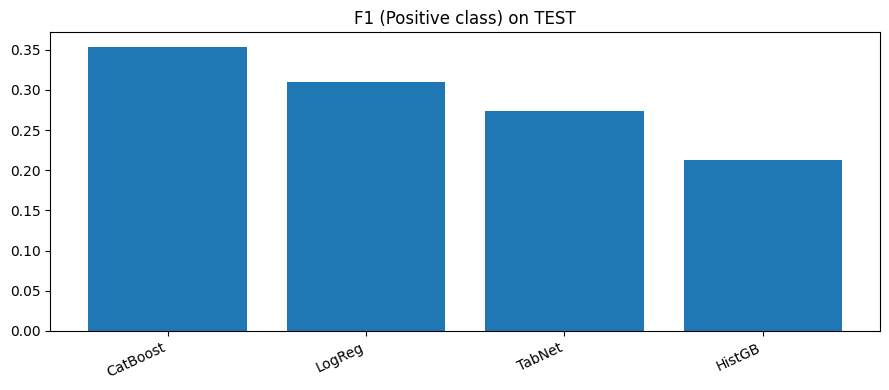

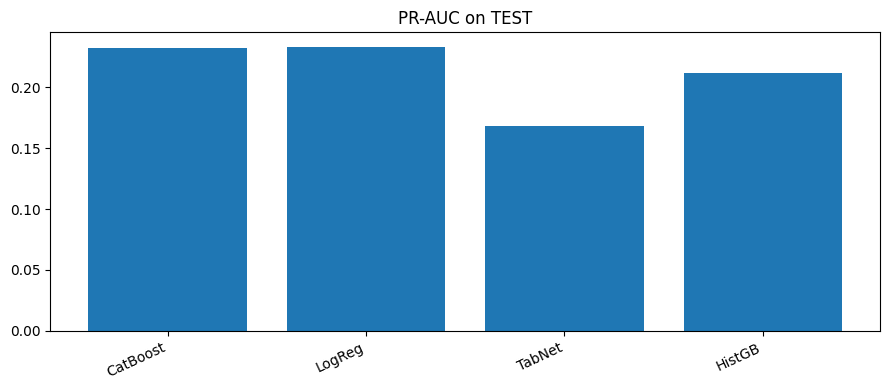

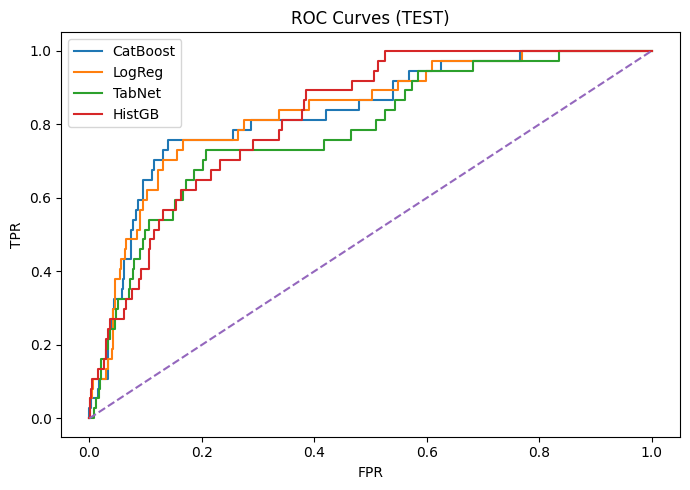

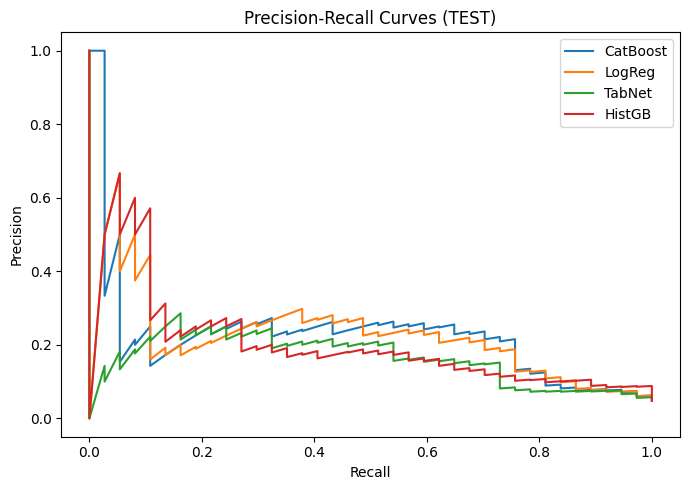


=== Classification report (BEST on TEST) ===
Model: CatBoost | thr=0.662266

              precision    recall  f1-score   support

           0     0.9754    0.9233    0.9486       730
           1     0.2632    0.5405    0.3540        37

    accuracy                         0.9048       767
   macro avg     0.6193    0.7319    0.6513       767
weighted avg     0.9410    0.9048    0.9199       767



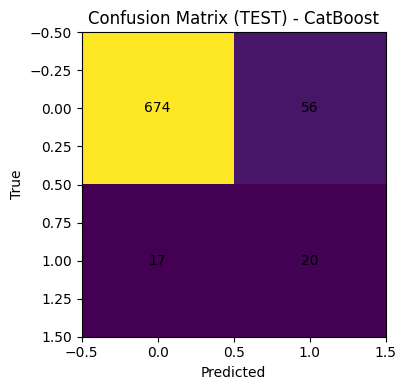

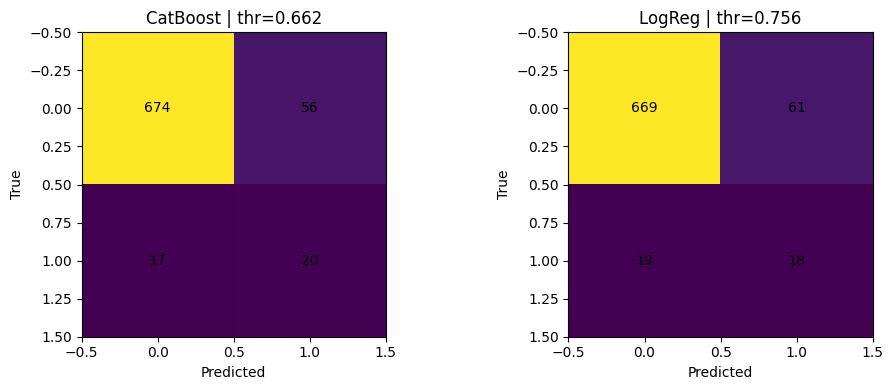

In [44]:
order = results_df["model"].tolist()

plt.figure(figsize=(9,4))
plt.bar(order, results_df["f1_pos"].values)
plt.title("F1 (Positive class) on TEST")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.bar(order, results_df["pr_auc"].values)
plt.title("PR-AUC on TEST")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

plot_curves_all(curves, order, title_suffix="(TEST)")

best_proba = probas_test[best_name]
best_pred  = (best_proba >= best_thr).astype(int)

print("\n=== Classification report (BEST on TEST) ===")
print(f"Model: {best_name} | thr={best_thr:.6f}\n")
print(classification_report(y_test_np, best_pred, digits=4))

cm = confusion_matrix(y_test_np, best_pred)
plt.figure(figsize=(4.5,4))
plt.imshow(cm)
plt.title(f"Confusion Matrix (TEST) - {best_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.show()

top2 = results_df.head(2)["model"].tolist()
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for ax, name in zip(axes, top2):
    thr = float(results_df[results_df["model"]==name]["thr"].iloc[0])
    proba = probas_test[name]
    pred = (proba >= thr).astype(int)
    cm2 = confusion_matrix(y_test_np, pred)
    ax.imshow(cm2)
    ax.set_title(f"{name} | thr={thr:.3f}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm2):
        ax.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.show()


# Stroke Prediction (CT)


unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

# ===== Correct paths =====
zip_file_path = '/content/drive/MyDrive/stroke-ct.zip'
folder_path   = '/content/drive/MyDrive/StrokeCTjune'

# ===== Ensure extraction folder exists =====
os.makedirs(folder_path, exist_ok=True)
print(f"📁 Folder ready: {folder_path}")

# ===== Check zip =====
if not os.path.isfile(zip_file_path):
    raise FileNotFoundError(f"❌ ZIP file not found at: {zip_file_path}")

# ===== Unzip =====
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print("✅ Successfully unzipped stroke-ct.zip")

# ===== Preview =====
for root, dirs, files in os.walk(folder_path):
    print("📂", root)
    print("   Files:", files[:5])
    break


📁 Folder ready: /content/drive/MyDrive/StrokeCTjune
✅ Successfully unzipped stroke-ct.zip
📂 /content/drive/MyDrive/StrokeCTjune
   Files: []


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [ ]:

stroke_paths = glob("/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke/*.jpg")  # or *.png
normal_paths = glob("/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Normal/*.jpg")

print("Stroke images:", len(stroke_paths))
print("Normal images:", len(normal_paths))


Stroke images: 950
Normal images: 1551


## Visualization

In [ ]:
# ===================== Filter RAW ONLY (before showing images & distribution) =====================
import os
from glob import glob

STROKE_DIR = "/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke"
NORMAL_DIR = "/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Normal"

AUG_KEYWORDS = [
    "aug", "augment", "flip", "flipped", "rot", "rotate", "rotation",
    "gen", "generated", "synthetic", "copy", "noise", "bright", "jitter",
    "mixup", "cutmix"
]

def is_augmented(path):
    base = os.path.basename(path).lower()
    return any(k in base for k in AUG_KEYWORDS)

# اقرأ كل الصور ثم فلتر RAW فقط
stroke_paths_all = glob(os.path.join(STROKE_DIR, "*.jpg")) + glob(os.path.join(STROKE_DIR, "*.png"))
normal_paths_all = glob(os.path.join(NORMAL_DIR, "*.jpg")) + glob(os.path.join(NORMAL_DIR, "*.png"))

stroke_paths = [p for p in stroke_paths_all if not is_augmented(p)]
normal_paths = [p for p in normal_paths_all if not is_augmented(p)]  # غالبًا لن يتغير، لكن للسلامة

print("✅ RAW ONLY distribution (after filtering):")
print("Stroke RAW:", len(stroke_paths))
print("Normal RAW:", len(normal_paths))


✅ RAW ONLY distribution (after filtering):
Stroke RAW: 950
Normal RAW: 1551


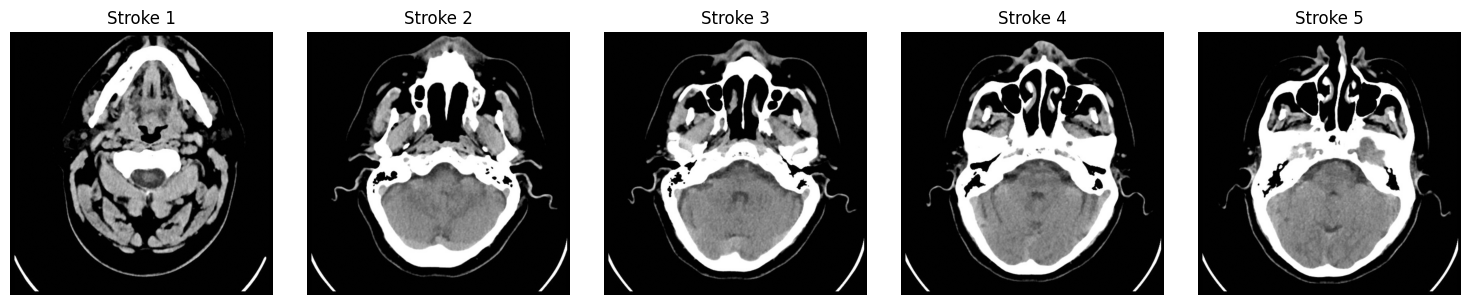

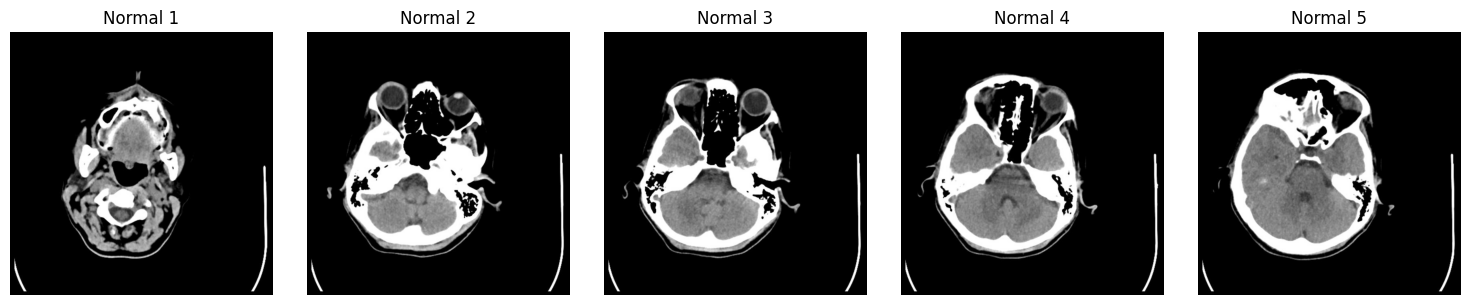

In [ ]:
def show_images(paths, title, n=5):
    if not paths:
        print(f"⚠️ No images found for {title}. Please check dataset loading.")
        return

    n = min(n, len(paths))

    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = cv2.imread(paths[i], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(stroke_paths, "Stroke")
show_images(normal_paths, "Normal")


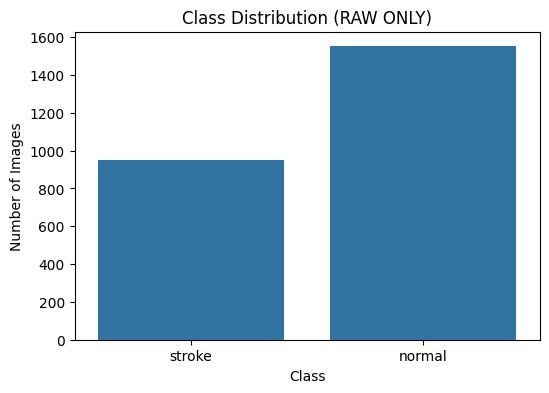

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['stroke'] * len(stroke_paths) + ['normal'] * len(normal_paths)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title("Class Distribution (RAW ONLY)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


Stroke images used: 950
Normal images used: 1551


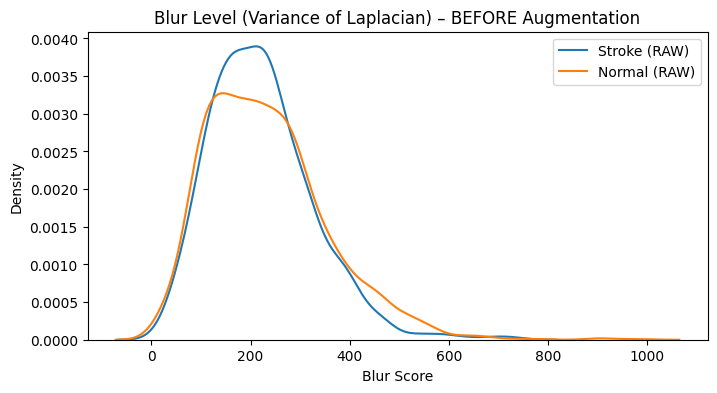

In [ ]:
# ===== Blur analysis BEFORE augmentation (ALL RAW DATA) =====
import cv2, os
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_blur(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

stroke_blur = [calculate_blur(p) for p in stroke_paths]
normal_blur = [calculate_blur(p) for p in normal_paths]

print("Stroke images used:", len(stroke_blur))
print("Normal images used:", len(normal_blur))

plt.figure(figsize=(8, 4))
sns.kdeplot(stroke_blur, label="Stroke (RAW)")
sns.kdeplot(normal_blur, label="Normal (RAW)")
plt.title("Blur Level (Variance of Laplacian) – BEFORE Augmentation")
plt.xlabel("Blur Score")
plt.legend()
plt.show()


Blur Detection (Image Quality Check)

## preprocessing:

1. CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
# ===== Preprocessing: CLAHE (RAW images only) =====
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 224

def preprocess_clahe(path, size=224):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (size, size))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    img = img / 255.0
    return img

X = []
y = []

for path in tqdm(stroke_paths):
    X.append(preprocess_clahe(path))
    y.append(1)

for path in tqdm(normal_paths):
    X.append(preprocess_clahe(path))
    y.append(0)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)



100%|██████████| 1551/1551 [00:08<00:00, 192.38it/s]


X shape: (2501, 224, 224, 1)
y shape: (2501,)


In [ ]:
IMG_SIZE = 224

X = []
y = []
for path in tqdm(stroke_paths):
    X.append(preprocess_clahe(path))
    y.append(1)
for path in tqdm(normal_paths):
    X.append(preprocess_clahe(path))
    y.append(0)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████| 1551/1551 [00:08<00:00, 189.94it/s]


X shape: (2501, 224, 224, 1)
y shape: (2501,)


In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

## Data Augmentation

/tmp/ipython-input-3208669074.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(0, 0.02*255*255), p=1.0) # Equivalent to iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)), var_limit is variance


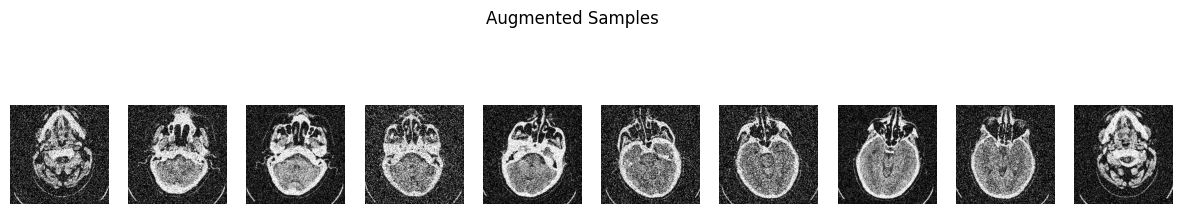

In [ ]:
import albumentations as A

# Define an Albumentations augmentation sequence
# Albumentations uses a different syntax and set of augmentations
augment = A.Compose([
    A.HorizontalFlip(p=0.5), # Equivalent to iaa.Fliplr(0.5)
    A.Rotate(limit=10, p=1.0), # Equivalent to iaa.Affine(rotate=(-10, 10)), limit is the maximum rotation in degrees
    A.RandomGamma(gamma_limit=(80, 120), p=1.0), # Equivalent to iaa.GammaContrast((0.8, 1.2)), gamma_limit is in percentage
    A.GaussNoise(var_limit=(0, 0.02*255*255), p=1.0) # Equivalent to iaa.AdditiveGaussianNoise(scale=(0, 0.02*255)), var_limit is variance
])

# Example: augment a batch
# Convert the preprocessed images back to uint8 [0, 255] for Albumentations
sample_images_uint8 = (X[:10] * 255).astype(np.uint8).squeeze() # Remove the channel dimension for grayscale

augmented_images = []
for img in sample_images_uint8:
    augmented_img = augment(image=img)['image']
    augmented_images.append(augmented_img)

# Convert back to numpy array
augmented_images = np.array(augmented_images)

# visualize augmented
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    # Add the channel dimension back for plotting if needed, although imshow handles it
    plt.imshow(augmented_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

In [ ]:
len(augmented_images)

10

In [ ]:
stroke_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke/'
stroke_images = os.listdir(stroke_dir)

len(stroke_images)

950

In [ ]:
import albumentations as A
import cv2
import os
from tqdm import tqdm

augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=1.0),
    A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)
])



stroke_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke'
aug_save_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/stroke_aug'
os.makedirs(aug_save_dir, exist_ok=True)

stroke_images = os.listdir(stroke_dir)
needed = len(normal_paths) - len(stroke_images)

for i in tqdm(range(needed)):
    img_name = stroke_images[i % len(stroke_images)]
    img_path = os.path.join(stroke_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Failed to load image: {img_path}")
        continue

    augmented = augment(image=img)['image']
    save_path = os.path.join(aug_save_dir, f"aug_{i}_{img_name}")
    cv2.imwrite(save_path, augmented)


/tmp/ipython-input-1657132320.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=1.0)
100%|██████████| 601/601 [00:12<00:00, 46.82it/s]


In [ ]:
needed = len(normal_paths) - len(stroke_images)
print(f"Number of augmented images needed: {needed}")

Number of augmented images needed: 601


In [ ]:
# ===================== Use ALL images (RAW + Augmented) =====================
import os
from glob import glob

STROKE_DIR = "/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Stroke"
NORMAL_DIR = "/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/Normal"

# قراءة جميع الصور بدون أي استثناء
stroke_paths = (
    glob(os.path.join(STROKE_DIR, "*.jpg")) +
    glob(os.path.join(STROKE_DIR, "*.png")) +
    glob(os.path.join(STROKE_DIR, "*.jpeg"))
)

normal_paths = (
    glob(os.path.join(NORMAL_DIR, "*.jpg")) +
    glob(os.path.join(NORMAL_DIR, "*.png")) +
    glob(os.path.join(NORMAL_DIR, "*.jpeg"))
)

print("📊 ALL DATA distribution (RAW + Augmented):")
print("Stroke images:", len(stroke_paths))
print("Normal images:", len(normal_paths))

📊 ALL DATA distribution (RAW + Augmented):
Stroke images: 1551
Normal images: 1551


ALL DATA counts → Stroke: 1551 | Normal: 1551


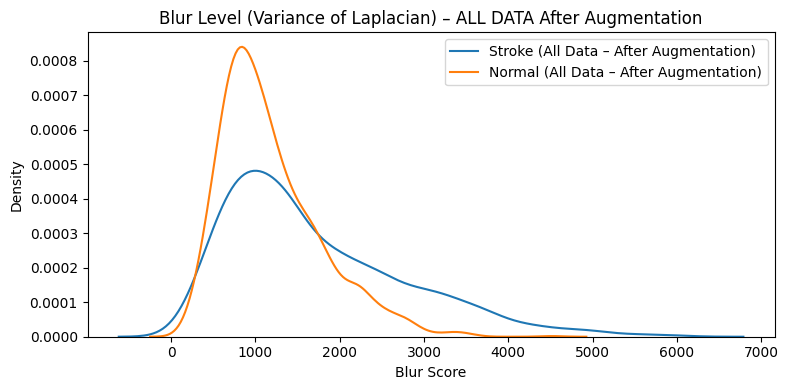

In [ ]:
# ===== Blur analysis on ALL DATA (RAW + Augmented, Training-style Augmentation) =====
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# المجلد الأساسي (قبل split)
BASE_DIR = "/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised"

# نفس الـ augmentation المستخدم في التدريب (online)
aug_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.10,
        hue=0.02
    ),
])

def blur_after_aug(path):
    img = Image.open(path).convert("L")
    aug_img = aug_tf(img)        # online augmentation
    aug_np = np.array(aug_img)
    return cv2.Laplacian(aug_np, cv2.CV_64F).var()

# قراءة كل الصور (RAW + Augmented) من المجلد الأساسي
stroke_paths_all = [
    os.path.join(BASE_DIR, "Stroke", f)
    for f in os.listdir(os.path.join(BASE_DIR, "Stroke"))
    if f.lower().endswith(('.jpg', '.png', '.jpeg'))
]

normal_paths_all = [
    os.path.join(BASE_DIR, "Normal", f)
    for f in os.listdir(os.path.join(BASE_DIR, "Normal"))
    if f.lower().endswith(('.jpg', '.png', '.jpeg'))
]

# حساب blur
stroke_blur_all = [blur_after_aug(p) for p in stroke_paths_all]
normal_blur_all = [blur_after_aug(p) for p in normal_paths_all]

print("ALL DATA counts → Stroke:", len(stroke_blur_all), "| Normal:", len(normal_blur_all))

# الرسم
plt.figure(figsize=(8, 4))
sns.kdeplot(stroke_blur_all, label="Stroke (All Data – After Augmentation)")
sns.kdeplot(normal_blur_all, label="Normal (All Data – After Augmentation)")
plt.title("Blur Level (Variance of Laplacian) – ALL DATA After Augmentation")
plt.xlabel("Blur Score")
plt.legend()
plt.tight_layout()
plt.show()


The blur analysis before augmentation shows relatively narrow distributions for both classes, reflecting the limited variability of the raw CT images.
After data augmentation, the blur distributions become significantly wider with heavier tails, indicating increased diversity in spatial and intensity variations.
This confirms that the augmentation strategy successfully enriches the training data and exposes the model to a broader range of image characteristics, which is essential for improving generalization

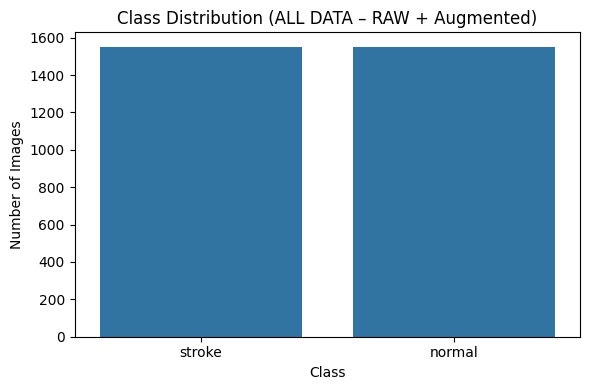

In [ ]:
# ===== Class Distribution (ALL DATA: RAW + Augmented) =====
import matplotlib.pyplot as plt
import seaborn as sns

# نفترض أن هذه القوائم قادمة من خلية "Use ALL images (RAW + Augmented)"
# stroke_paths و normal_paths تمثلان كل الصور في المجلدات

labels = ['stroke'] * len(stroke_paths) + ['normal'] * len(normal_paths)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title("Class Distribution (ALL DATA – RAW + Augmented)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [ ]:
import shutil

for file in os.listdir(aug_save_dir):
    shutil.move(os.path.join(aug_save_dir, file), stroke_dir)


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dataset_dir = '/content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised/'

val_ratio = 0.15
test_ratio = 0.15
train_ratio = 1.0 - val_ratio - test_ratio

base_output_dir = 'dataset_split'
splits = ['train', 'val', 'test']
classes = ['Stroke', 'Normal']

for split in splits:
    for cls in classes:
        split_dir = os.path.join(base_output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)

for cls in classes:
    cls_path = os.path.join(original_dataset_dir, cls)
    images = os.listdir(cls_path)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Train + Temp
    train_imgs, temp_imgs = train_test_split(images, test_size=(val_ratio + test_ratio), random_state=42)

    # Val + Test
    val_size = val_ratio / (val_ratio + test_ratio)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(1 - val_size), random_state=42)


    for img in train_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(base_output_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(base_output_dir, 'val', cls, img))
    for img in test_imgs:
        shutil.copy2(os.path.join(cls_path, img), os.path.join(base_output_dir, 'test', cls, img))

print("successfully✅ ")


successfully✅ 


### فحص ومعالجة تسريب محتمل بسبب التشابه

In [ ]:
# ✅ Leak check: identical files (SHA1) + near-duplicates (aHash)
import os, hashlib
import numpy as np
from PIL import Image

split_root = "/content/dataset_split"  # يحتوي train/val/test وبداخلها Normal/Stroke
splits = ["train", "val", "test"]
classes = ["Normal", "Stroke"]

def sha1_file(path, chunk=1<<20):
    h = hashlib.sha1()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def ahash(path, size=16):
    img = Image.open(path).convert("L").resize((size, size))
    arr = np.asarray(img, dtype=np.float32)
    m = arr.mean()
    bits = (arr > m).astype(np.uint8).flatten()
    # pack to hex string
    return hashlib.sha1(bits.tobytes()).hexdigest()

def collect_hashes(hash_fn):
    H = {s: {} for s in splits}
    for s in splits:
        for c in classes:
            d = os.path.join(split_root, s, c)
            if not os.path.isdir(d):
                continue
            for fn in os.listdir(d):
                p = os.path.join(d, fn)
                if os.path.isfile(p) and fn.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp")):
                    h = hash_fn(p)
                    H[s].setdefault(h, []).append(p)
    return H

def overlap_report(H, name=""):
    def count_pairs(a, b):
        inter = set(H[a].keys()) & set(H[b].keys())
        n = sum(min(len(H[a][k]), len(H[b][k])) for k in inter)
        return len(inter), n, inter

    pairs = [("train","val"), ("train","test"), ("val","test")]
    print(f"\n=== Overlap by {name} ===")
    for a,b in pairs:
        uniq_hashes, approx_files, inter = count_pairs(a,b)
        print(f"{a} ↔ {b}: shared_hashes={uniq_hashes}, shared_files≈{approx_files}")
    # show examples (up to 5 hashes) if any overlap
    a,b = "train","val"
    inter = set(H[a].keys()) & set(H[b].keys())
    if inter:
        print("\nExamples (train vs val):")
        for k in list(inter)[:5]:
            print("HASH:", k)
            print("  train:", H[a][k][:2])
            print("  val  :", H[b][k][:2])

# 1) Exact duplicates (byte-identical)
H_sha1 = collect_hashes(sha1_file)
overlap_report(H_sha1, "SHA1 (exact bytes)")

# 2) Near-duplicates (same visual after resize+gray thresholding)
H_ah = collect_hashes(ahash)
overlap_report(H_ah, "aHash (near-duplicate)")



=== Overlap by SHA1 (exact bytes) ===
train ↔ val: shared_hashes=0, shared_files≈0
train ↔ test: shared_hashes=0, shared_files≈0
val ↔ test: shared_hashes=0, shared_files≈0

=== Overlap by aHash (near-duplicate) ===
train ↔ val: shared_hashes=21, shared_files≈23
train ↔ test: shared_hashes=27, shared_files≈27
val ↔ test: shared_hashes=6, shared_files≈6

Examples (train vs val):
HASH: 4db87ff624e2afd88cf0a1770a4b361113c760cc
  train: ['/content/dataset_split/train/Stroke/70 (39).jpg']
  val  : ['/content/dataset_split/val/Stroke/aug_170_70 (39).jpg']
HASH: eede135b7a21929852a942857c55794b0c4e58a9
  train: ['/content/dataset_split/train/Stroke/92 (25).jpg']
  val  : ['/content/dataset_split/val/Stroke/92 (27).jpg']
HASH: 6582086ddff96bf775c6962ee6b41cee12beaaa5
  train: ['/content/dataset_split/train/Normal/112 (17).jpg']
  val  : ['/content/dataset_split/val/Normal/112 (16).jpg']
HASH: f0ba9561555387bf7cf8fb14588c50a17a91bd64
  train: ['/content/dataset_split/train/Normal/64 (17).jpg']

### Rebuild dataset_split safely (no aug leakage + group-split by aHash)

In [ ]:

import os, shutil, glob, random, hashlib
import numpy as np
from PIL import Image
from collections import defaultdict
from datetime import datetime

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# =========================
# 0) Settings
# =========================
OUT_DIR = "/content/dataset_split"     # will be rebuilt
CLASSES = ["Normal", "Stroke"]
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

# split ratios
TEST_RATIO = 0.15
VAL_RATIO_FROM_REMAIN = 0.1765  # ≈ 0.15 overall if test=0.15 (same as you used earlier)
# overall approx: train 0.70, val 0.15, test 0.15

# =========================
# 1) Find best source root automatically
#    (a folder that contains Normal/ and Stroke/ with many images)
# =========================
def count_images_in(root):
    total = 0
    for cls in CLASSES:
        p = os.path.join(root, cls)
        if not os.path.isdir(p):
            return 0
        for f in os.listdir(p):
            if f.lower().endswith(IMG_EXTS):
                total += 1
    return total

candidates = []
for root, dirs, files in os.walk("/content"):
    # skip existing split output
    if OUT_DIR in root:
        continue
    # look for class folders
    if all(os.path.isdir(os.path.join(root, c)) for c in CLASSES):
        n = count_images_in(root)
        if n > 0:
            candidates.append((n, root))

if not candidates:
    raise FileNotFoundError(
        "❌ لم أجد مجلد مصدر يحتوي Normal/ و Stroke/ داخل /content.\n"
        "ضع بياناتك الخام في مجلد مثل /content/dataset_raw/Normal و /content/dataset_raw/Stroke ثم أعد تشغيل الخلية."
    )

candidates.sort(reverse=True)
SRC_ROOT = candidates[0][1]
print(f"✅ Using source root: {SRC_ROOT}")
print(f"✅ Total images (rough count): {candidates[0][0]}")

# =========================
# 2) Collect ORIGINAL images only (skip aug_ etc.)
# =========================
def is_aug(name: str):
    n = name.lower()
    return n.startswith("aug_") or "aug_" in n or "/aug_" in n or "aug" in n  # conservative

items = []  # (path, label)
for cls_i, cls in enumerate(CLASSES):
    cls_dir = os.path.join(SRC_ROOT, cls)
    files = sorted([f for f in os.listdir(cls_dir) if f.lower().endswith(IMG_EXTS)])
    for f in files:
        if is_aug(f):
            continue
        items.append((os.path.join(cls_dir, f), cls_i))

print(f"✅ Original-only images: {len(items)} (aug skipped)")

if len(items) < 50:
    print("⚠️ Warning: عدد الصور قليل جداً بعد استبعاد aug. تأكد أن مجلد المصدر صحيح.")

# =========================
# 3) aHash for grouping near-duplicates
# =========================
def ahash(path, size=8):
    try:
        img = Image.open(path).convert("L").resize((size, size), Image.BILINEAR)
        arr = np.asarray(img, dtype=np.float32)
        med = arr.mean()
        bits = (arr > med).astype(np.uint8).flatten()
        # convert bits to hex string (stable group key)
        out = 0
        for b in bits:
            out = (out << 1) | int(b)
        return f"{out:0{size*size//4}x}"
    except Exception:
        return None

groups = defaultdict(list)   # hash -> list of (path,label)
bad = 0
for p, y in items:
    h = ahash(p)
    if h is None:
        bad += 1
        continue
    groups[h].append((p, y))

print(f"✅ aHash groups: {len(groups)} | unreadable: {bad}")

# Each group has a "majority" label; if mixed labels exist, keep them together anyway (safer)
group_list = []
for h, lst in groups.items():
    labels = [y for _, y in lst]
    maj = int(np.bincount(labels).argmax())
    group_list.append((h, maj, lst))

# =========================
# 4) Stratified split by GROUP (so near-duplicates stay together)
# =========================
# Build index arrays
H = [g[0] for g in group_list]
Y = np.array([g[1] for g in group_list], dtype=int)

# stratified split on groups manually
def stratified_split(indices, y, test_size, seed=SEED):
    rng = np.random.default_rng(seed)
    idx0 = [i for i in indices if y[i] == 0]
    idx1 = [i for i in indices if y[i] == 1]
    rng.shuffle(idx0); rng.shuffle(idx1)

    n0 = int(round(len(idx0) * test_size))
    n1 = int(round(len(idx1) * test_size))

    test = idx0[:n0] + idx1[:n1]
    rest = idx0[n0:] + idx1[n1:]
    rng.shuffle(test); rng.shuffle(rest)
    return rest, test

all_idx = list(range(len(group_list)))
rest_idx, test_idx = stratified_split(all_idx, Y, TEST_RATIO, seed=SEED)
train_idx, val_idx = stratified_split(rest_idx, Y, VAL_RATIO_FROM_REMAIN, seed=SEED+1)

def expand_groups(gidx):
    out = []
    for i in gidx:
        out.extend(group_list[i][2])  # list of (path,label)
    return out

train_items = expand_groups(train_idx)
val_items   = expand_groups(val_idx)
test_items  = expand_groups(test_idx)

def count_by_label(lst):
    ys = [y for _, y in lst]
    return {0: int(np.sum(np.array(ys)==0)), 1: int(np.sum(np.array(ys)==1))}

print("Split sizes (images):")
print(" train:", len(train_items), count_by_label(train_items))
print(" val  :", len(val_items),   count_by_label(val_items))
print(" test :", len(test_items),  count_by_label(test_items))

# =========================
# 5) Backup old split + write new split
# =========================
if os.path.exists(OUT_DIR):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    backup = OUT_DIR + "_backup_" + ts
    shutil.move(OUT_DIR, backup)
    print(f"📦 Backed up old split to: {backup}")

for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(OUT_DIR, split, cls), exist_ok=True)

def copy_items(lst, split_name):
    for src, y in lst:
        cls = CLASSES[y]
        dst = os.path.join(OUT_DIR, split_name, cls, os.path.basename(src))
        # avoid name collisions
        if os.path.exists(dst):
            base, ext = os.path.splitext(os.path.basename(src))
            k = 1
            while os.path.exists(dst):
                dst = os.path.join(OUT_DIR, split_name, cls, f"{base}__{k}{ext}")
                k += 1
        shutil.copy2(src, dst)

copy_items(train_items, "train")
copy_items(val_items,   "val")
copy_items(test_items,  "test")

print(f"✅ Rebuilt split at: {OUT_DIR}")

# =========================
# 6) Quick leakage check (aHash overlap only) after rebuild
# =========================
def list_images(split):
    out = []
    for cls in CLASSES:
        p = os.path.join(OUT_DIR, split, cls)
        out += glob.glob(os.path.join(p, "*"))
    return [f for f in out if f.lower().endswith(IMG_EXTS)]

def ahash_set(paths):
    s = set()
    for p in paths:
        h = ahash(p)
        if h is not None:
            s.add(h)
    return s

tr = list_images("train")
va = list_images("val")
te = list_images("test")

Hs_tr = ahash_set(tr)
Hs_va = ahash_set(va)
Hs_te = ahash_set(te)

print("\n=== Post-rebuild aHash overlap (should be 0) ===")
print("train ↔ val :", len(Hs_tr & Hs_va))
print("train ↔ test:", len(Hs_tr & Hs_te))
print("val ↔ test  :", len(Hs_va & Hs_te))


✅ Using source root: /content/drive/MyDrive/StrokeCTjune/Brain_Data_Organised
✅ Total images (rough count): 3102
✅ Original-only images: 2501 (aug skipped)
✅ aHash groups: 1211 | unreadable: 0
Split sizes (images):
 train: 1746 {0: 1067, 1: 679}
 val  : 361 {0: 236, 1: 125}
 test : 394 {0: 248, 1: 146}
📦 Backed up old split to: /content/dataset_split_backup_20260102_214956
✅ Rebuilt split at: /content/dataset_split

=== Post-rebuild aHash overlap (should be 0) ===
train ↔ val : 0
train ↔ test: 0
val ↔ test  : 0


## فحص بيانات dataset_split_clean

In [ ]:
# ✅ Audit + Fix dataset_split (structure: split/class/images)
# Output: /content/dataset_split_clean/{train,val,test}/{Normal,Stroke}

!pip -q install --no-cache-dir pillow imagehash

import os, shutil, random, hashlib
from collections import defaultdict, Counter
import numpy as np
from PIL import Image
import imagehash

SEED = 42
random.seed(SEED); np.random.seed(SEED)

SRC = "/content/dataset_split"
OUT = "/content/dataset_split_clean"
SPLITS = ["train","val","test"]
EXTS = (".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp")
RATIO = {"train":0.70, "val":0.15, "test":0.15}

def get_classes(src_root):
    # infer classes from train (or first available split)
    for sp in SPLITS:
        sp_dir = os.path.join(src_root, sp)
        if os.path.isdir(sp_dir):
            cls = sorted([d for d in os.listdir(sp_dir) if os.path.isdir(os.path.join(sp_dir,d))])
            if cls: return cls
    return []

def list_items_split_class(src_root, classes):
    items = []
    for sp in SPLITS:
        for c in classes:
            d = os.path.join(src_root, sp, c)
            if not os.path.isdir(d):
                continue
            for fn in os.listdir(d):
                fp = os.path.join(d, fn)
                if os.path.isfile(fp) and fn.lower().endswith(EXTS):
                    items.append((sp, c, fp))
    return items

def sha1_file(path, chunk=1<<20):
    h = hashlib.sha1()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def ahash_file(path):
    try:
        with Image.open(path) as im:
            im = im.convert("RGB")
            return str(imagehash.average_hash(im))
    except Exception:
        return None

def overlap_report(hmap, name):
    leak = []
    for h, lst in hmap.items():
        if len({sp for sp,_,_ in lst}) > 1:
            leak.append((h,lst))
    pairs = [("train","val"),("train","test"),("val","test")]
    print(f"\n=== Overlap by {name} ===")
    for a,b in pairs:
        shared = 0
        for _, lst in leak:
            s = {sp for sp,_,_ in lst}
            if a in s and b in s:
                shared += 1
        print(f"{a} ↔ {b}: shared_hashes={shared}")
    return leak

# -----------------------------
# 1) Scan
# -----------------------------
assert os.path.isdir(SRC), f"Not found: {SRC}"
CLASSES = get_classes(SRC)
assert len(CLASSES) >= 2, f"Could not infer classes. Found: {CLASSES}"
print("✅ Classes:", CLASSES)

items = list_items_split_class(SRC, CLASSES)
print("✅ Total files:", len(items))

counts = Counter((sp,c) for sp,c,_ in items)
print("\n=== Counts per split/class ===")
for sp in SPLITS:
    row = {c: counts.get((sp,c),0) for c in CLASSES}
    print(sp, row, "| total:", sum(row.values()))

# -----------------------------
# 2) Hashing
# -----------------------------
print("\n⏳ Computing SHA1 + aHash ...")
sha_map = defaultdict(list)
ah_map  = defaultdict(list)
bad = 0

for sp,c,fp in items:
    try:
        s = sha1_file(fp); sha_map[s].append((sp,c,fp))
        a = ahash_file(fp)
        if a is not None:
            ah_map[a].append((sp,c,fp))
    except Exception:
        bad += 1

leak_sha = overlap_report(sha_map, "SHA1 (exact bytes)")
leak_ah  = overlap_report(ah_map,  "aHash (near-duplicate)")
print("Unreadable files:", bad)

# -----------------------------
# 3) Build CLEAN split grouped by aHash (prevents near-dup leakage)
#    Representative per group (prefer non-aug + prefer coming from train)
# -----------------------------
print("\n🧹 Building CLEAN split at:", OUT)
if os.path.isdir(OUT):
    shutil.rmtree(OUT)
for sp in SPLITS:
    for c in CLASSES:
        os.makedirs(os.path.join(OUT, sp, c), exist_ok=True)

# groups from aHash; if no aHash, fallback to SHA1 group
group_to_list = {}
for a,lst in ah_map.items():
    group_to_list[f"AH_{a}"] = lst
# add items that never appeared in any aHash group (rare) via SHA1
in_any_ah = set()
for lst in group_to_list.values():
    for _,_,fp in lst: in_any_ah.add(fp)

for s,lst in sha_map.items():
    for sp,c,fp in lst:
        if fp not in in_any_ah:
            group_to_list[f"SH_{s}"] = [(sp,c,fp)]

def rep_pick(lst):
    def score(t):
        sp,c,fp = t
        bn = os.path.basename(fp).lower()
        aug = (bn.startswith("aug_") or "aug_" in bn)
        # prefer: non-aug, then from train
        return (1 if aug else 0, 0 if sp=="train" else 1)
    return sorted(lst, key=score)[0]

groups = []
for gid,lst in group_to_list.items():
    sp,c,fp = rep_pick(lst)
    groups.append((c, fp))

# stratified split per class on groups
by_class = defaultdict(list)
for c, fp in groups:
    by_class[c].append(fp)

def split_list(lst, ratios):
    lst = lst[:]
    random.shuffle(lst)
    n = len(lst)
    n_tr = int(round(ratios["train"]*n))
    n_va = int(round(ratios["val"]*n))
    n_te = n - n_tr - n_va
    return lst[:n_tr], lst[n_tr:n_tr+n_va], lst[n_tr+n_va:]

assign = {"train":[], "val":[], "test":[]}
for c, lst in by_class.items():
    tr, va, te = split_list(lst, RATIO)
    assign["train"] += [(c, fp) for fp in tr]
    assign["val"]   += [(c, fp) for fp in va]
    assign["test"]  += [(c, fp) for fp in te]

def safe_copy(src_fp, dst_dir):
    bn = os.path.basename(src_fp)
    dst_fp = os.path.join(dst_dir, bn)
    if os.path.exists(dst_fp):
        root, ext = os.path.splitext(bn)
        i = 1
        while os.path.exists(os.path.join(dst_dir, f"{root}__{i}{ext}")):
            i += 1
        dst_fp = os.path.join(dst_dir, f"{root}__{i}{ext}")
    shutil.copy2(src_fp, dst_fp)

for sp in SPLITS:
    for c, fp in assign[sp]:
        safe_copy(fp, os.path.join(OUT, sp, c))

# -----------------------------
# 4) Recheck leakage on CLEAN
# -----------------------------
items2 = list_items_split_class(OUT, CLASSES)
counts2 = Counter((sp,c) for sp,c,_ in items2)
print("\n✅ CLEAN counts:")
for sp in SPLITS:
    row = {c: counts2.get((sp,c),0) for c in CLASSES}
    print(sp, row, "| total:", sum(row.values()))

ah_map2 = defaultdict(list)
for sp,c,fp in items2:
    a = ahash_file(fp)
    if a is not None:
        ah_map2[a].append((sp,c,fp))

_ = overlap_report(ah_map2, "aHash (CLEAN)")
print("\n➡️ Use this for training from now on:", OUT)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 8.0 MB/s eta 0:00:00
✅ Classes: ['Normal', 'Stroke']
✅ Total files: 2501

=== Counts per split/class ===
train {'Normal': 1067, 'Stroke': 679} | total: 1746
val {'Normal': 236, 'Stroke': 125} | total: 361
test {'Normal': 248, 'Stroke': 146} | total: 394

⏳ Computing SHA1 + aHash ...

=== Overlap by SHA1 (exact bytes) ===
train ↔ val: shared_hashes=0
train ↔ test: shared_hashes=0
val ↔ test: shared_hashes=0

=== Overlap by aHash (near-duplicate) ===
train ↔ val: shared_hashes=61
train ↔ test: shared_hashes=77
val ↔ test: shared_hashes=20
Unreadable files: 0

🧹 Building CLEAN split at: /content/dataset_split_clean

✅ CLEAN counts:
train {'Normal': 618, 'Stroke': 328} | total: 946
val {'Normal': 132, 'Stroke': 70} | total: 202
test {'Normal': 133, 'Stroke': 70} | total: 203

=== Overlap by aHash (CLEAN) ===
train ↔ val: shared_hashes=0
train ↔ test: shared_hashes=0
val ↔ test: shared_hashes=0

➡️ Use this for training from now on:

## Swin Large 384
 (وإذا لم يتوفر تلقائيًا تتحول إلى Swin Base 384)، مع:

KFold ensemble

EMA (تحسن الاستقرار)

TTA (flip) على التست

مرحلتين: head ثم fine-tune لآخر blocks

Threshold مضبوط على VAL لتعظيم Accuracy

In [ ]:
# ✅ Swin STRONG (FIXED) + 5-Fold CV + F1-threshold tuning + FINAL TEST eval
!pip -q install -U timm

import os, random, math, copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import timm
from timm.data import resolve_data_config, create_transform
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_DIR = "/content/dataset_split_clean"
POOL_DIRS = [os.path.join(DATA_DIR, "train"), os.path.join(DATA_DIR, "val")]  # train+val pool
TEST_DIR  = os.path.join(DATA_DIR, "test")

CLASSES = ["Normal", "Stroke"]  # ✅ تثبيت ترتيب الكلاسات
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASSES)}

# -----------------------------
# 0) Dataset with FIXED mapping
# -----------------------------
class FixedImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [c for c in CLASSES if os.path.isdir(os.path.join(directory, c))]
        if set(classes) != set(CLASSES):
            raise ValueError(f"Expected folders {CLASSES} inside {directory}, found {classes}")
        return CLASSES, CLASS_TO_IDX

# -----------------------------
# 1) Collect pool samples
# -----------------------------
def collect_samples(dirs):
    paths, labels = [], []
    for d in dirs:
        ds = FixedImageFolder(d, transform=None)
        for p, y in ds.samples:
            paths.append(p)
            labels.append(int(y))
    return np.array(paths), np.array(labels)

pool_paths, pool_y = collect_samples(POOL_DIRS)
test_ds_base = FixedImageFolder(TEST_DIR, transform=None)
print("Pool train+val:", len(pool_paths), "| Test:", len(test_ds_base))
print("class_to_idx test:", test_ds_base.class_to_idx)

# -----------------------------
# 2) Model + transforms (timm correct)
# -----------------------------
MODEL_NAME = "swin_large_patch4_window12_384.ms_in22k_ft_in1k"  # قوي
num_classes = 2

# resolve config from pretrained weights
tmp_model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)
cfg = resolve_data_config({}, model=tmp_model)
# ✅ transforms صحيحة للموديل + Augment لطيف (CT لا يتحمل ColorJitter قوي)
train_tf = create_transform(**cfg, is_training=True)
eval_tf  = create_transform(**cfg, is_training=False)

# Optional: make train aug less destructive (CT)
train_tf = transforms.Compose([
    transforms.Resize((cfg["input_size"][1], cfg["input_size"][2])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(7),
    transforms.ToTensor(),
    transforms.Normalize(mean=cfg["mean"], std=cfg["std"]),
])

# -----------------------------
# 3) Custom dataset from file paths
# -----------------------------
from PIL import Image
class PathDataset(Dataset):
    def __init__(self, paths, labels, tfm):
        self.paths = list(paths)
        self.labels = list(labels)
        self.tfm = tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        return self.tfm(img), int(self.labels[i])

# -----------------------------
# 4) Helpers: metrics + threshold by F1
# -----------------------------
def pick_thr_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    f1_thr = f1[1:]
    bi = int(np.nanargmax(f1_thr))
    return float(thr[bi]), float(f1_thr[bi])

@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs, ys = [], []
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs.append(p)
        ys.append(y.numpy())
    return np.concatenate(probs), np.concatenate(ys)

# -----------------------------
# 5) Train one fold (head warmup + fine-tune)
# -----------------------------
def run_fold(train_idx, val_idx, fold_id):
    # datasets
    tr_ds = PathDataset(pool_paths[train_idx], pool_y[train_idx], train_tf)
    va_ds = PathDataset(pool_paths[val_idx],   pool_y[val_idx],   eval_tf)

    # loaders
    BATCH=16  # A100 ممتاز
    tr_ld = DataLoader(tr_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
    va_ld = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

    # model
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes).to(device)

    # loss + weights (خفيفة)
    pos = (pool_y[train_idx]==1).sum()
    neg = (pool_y[train_idx]==0).sum()
    w_pos = neg / max(pos,1)
    class_w = torch.tensor([1.0, float(w_pos)], device=device)
    criterion = nn.CrossEntropyLoss(weight=class_w)

    # --- stage 1: train head only ---
    for n,p in model.named_parameters():
        p.requires_grad = ("head" in n) or ("classifier" in n)

    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4, weight_decay=0.05)
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))
    best_state, best_val_pr = None, -1

    def train_epochs(E, tag):
        nonlocal best_state, best_val_pr
        for ep in range(1, E+1):
            model.train()
            tot=0; loss_sum=0
            for x,y in tr_ld:
                x=x.to(device, non_blocking=True); y=y.to(device, non_blocking=True)
                opt.zero_grad(set_to_none=True)
                with torch.amp.autocast("cuda", enabled=(device.type=="cuda")):
                    logits = model(x)
                    loss = criterion(logits, y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
                loss_sum += float(loss.item())*x.size(0); tot += x.size(0)

            # val pr/roc
            va_proba, va_y = predict_proba(model, va_ld)
            val_pr  = average_precision_score(va_y, va_proba)
            val_roc = roc_auc_score(va_y, va_proba)
            if val_pr > best_val_pr:
                best_val_pr = val_pr
                best_state = copy.deepcopy(model.state_dict())

            print(f"[F{fold_id}-{tag}] Epoch {ep}/{E} | loss={loss_sum/max(tot,1):.4f} | val_pr={val_pr:.4f} | val_roc={val_roc:.4f}")

    train_epochs(2, "HEAD")

    # --- stage 2: fine-tune last blocks فقط (أقوى من تدريب كامل ويستقر أسرع) ---
    # Swin blocks naming: "layers.3" آخر stage غالباً
    for n,p in model.named_parameters():
        p.requires_grad = ("layers.3" in n) or ("head" in n) or ("classifier" in n)

    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, weight_decay=0.05)
    train_epochs(10, "FINE")

    # load best PR checkpoint
    model.load_state_dict(best_state)

    # choose threshold by VAL F1 (مهم جداً)
    va_proba, va_y = predict_proba(model, va_ld)
    thr, val_f1 = pick_thr_f1(va_y, va_proba)
    val_pr  = average_precision_score(va_y, va_proba)
    val_roc = roc_auc_score(va_y, va_proba)

    return model, thr, val_f1, val_pr, val_roc

# -----------------------------
# 6) 5-Fold CV
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold_models, fold_thrs, fold_rows = [], [], []

for fi, (tr_i, va_i) in enumerate(skf.split(pool_paths, pool_y), start=1):
    print("\n" + "="*18, f"FOLD {fi}/5", "="*18)
    model, thr, val_f1, val_pr, val_roc = run_fold(tr_i, va_i, fi)
    fold_models.append(model)
    fold_thrs.append(thr)
    fold_rows.append([fi, thr, val_f1, val_pr, val_roc])
    print(f"✅ Fold {fi} | best_thr={thr:.4f} | val_f1={val_f1:.4f} | val_pr={val_pr:.4f} | val_roc={val_roc:.4f}")

print("\nFold summary:")
import pandas as pd
fold_df = pd.DataFrame(fold_rows, columns=["fold","thr","val_f1","val_pr","val_roc"])
display(fold_df)

ens_thr = float(np.median(fold_thrs))
print(f"\n✅ Ensemble threshold (median folds) = {ens_thr:.4f}")

# -----------------------------
# 7) FINAL TEST (ensemble avg proba)
# -----------------------------
test_ds = FixedImageFolder(TEST_DIR, transform=eval_tf)
test_ld = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

all_fold_proba = []
y_test = np.array([y for _,y in test_ds.samples], dtype=int)

for i, m in enumerate(fold_models, start=1):
    p, _ = predict_proba(m, test_ld)
    all_fold_proba.append(p)

proba_ens = np.mean(np.vstack(all_fold_proba), axis=0)
pred_ens  = (proba_ens >= ens_thr).astype(int)

test_roc = roc_auc_score(y_test, proba_ens)
test_pr  = average_precision_score(y_test, proba_ens)

print("TEST ROC-AUC:", test_roc)
print("TEST PR-AUC :", test_pr)
print("\n=== TEST classification report (Ensemble Swin) ===")
print(classification_report(y_test, pred_ens, target_names=CLASSES, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_ens))



Device: cuda
Pool train+val: 1148 | Test: 203
class_to_idx test: {'Normal': 0, 'Stroke': 1}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



================== FOLD 1/5 ==================
[F1-HEAD] Epoch 1/2 | loss=0.7124 | val_pr=0.4218 | val_roc=0.5951
[F1-HEAD] Epoch 2/2 | loss=0.6807 | val_pr=0.4545 | val_roc=0.6329
[F1-FINE] Epoch 1/10 | loss=0.6656 | val_pr=0.5315 | val_roc=0.6560
[F1-FINE] Epoch 2/10 | loss=0.5986 | val_pr=0.6701 | val_roc=0.7758
[F1-FINE] Epoch 3/10 | loss=0.5756 | val_pr=0.7261 | val_roc=0.8148
[F1-FINE] Epoch 4/10 | loss=0.4993 | val_pr=0.7328 | val_roc=0.8213
[F1-FINE] Epoch 5/10 | loss=0.4955 | val_pr=0.7365 | val_roc=0.8399
[F1-FINE] Epoch 6/10 | loss=0.4370 | val_pr=0.7852 | val_roc=0.8741
[F1-FINE] Epoch 7/10 | loss=0.3930 | val_pr=0.7616 | val_roc=0.8635
[F1-FINE] Epoch 8/10 | loss=0.3651 | val_pr=0.7901 | val_roc=0.8802
[F1-FINE] Epoch 9/10 | loss=0.2955 | val_pr=0.7878 | val_roc=0.8760
[F1-FINE] Epoch 10/10 | loss=0.3230 | val_pr=0.8151 | val_roc=0.8869
✅ Fold 1 | best_thr=0.2379 | val_f1=0.7442 | val_pr=0.8151 | val_roc=0.8869

================== FOLD 2/5 ==================
[F2-HEAD] Epo

,fold,thr,val_f1,val_pr,val_roc
0,1,0.237880,0.744186,0.815134,0.886917
1,2,0.590860,0.728395,0.830519,0.869083
2,3,0.316878,0.731959,0.762343,0.853417
3,4,0.507842,0.740741,0.834374,0.871730
4,5,0.511002,0.750000,0.824423,0.890295



✅ Ensemble threshold (median folds) = 0.5078
TEST ROC-AUC: 0.9184747583243824
TEST PR-AUC : 0.8629020452490754

=== TEST classification report (Ensemble Swin) ===
              precision    recall  f1-score   support

      Normal     0.8741    0.8872    0.8806       133
      Stroke     0.7794    0.7571    0.7681        70

    accuracy                         0.8424       203
   macro avg     0.8267    0.8222    0.8244       203
weighted avg     0.8414    0.8424    0.8418       203

Confusion Matrix:
 [[118  15]
 [ 17  53]]


## ConvNeXt K-Fold Ensemble (train+val pool) + threshold tuning + TEST

In [ ]:
# ✅ Fair ConvNeXt K-Fold Ensemble (train+val pool) + threshold tuning + TEST report  [FIXED timm model name]
!pip -q install timm

import os, random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report, confusion_matrix
)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DATA_DIR = "/content/dataset_split_clean"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# -----------------------------
# 1) Load pool (train+val) + test
# -----------------------------
train_ds = ImageFolder(os.path.join(DATA_DIR, "train"))
val_ds   = ImageFolder(os.path.join(DATA_DIR, "val"))
test_ds  = ImageFolder(os.path.join(DATA_DIR, "test"))

classes = train_ds.classes
assert classes == val_ds.classes == test_ds.classes, "Class order mismatch between splits!"
print("Classes:", classes)

pool_samples = train_ds.samples + val_ds.samples
test_samples = test_ds.samples

pool_paths  = [p for p,_ in pool_samples]
pool_labels = np.array([y for _,y in pool_samples], dtype=int)

test_paths  = [p for p,_ in test_samples]
test_labels = np.array([y for _,y in test_samples], dtype=int)

print(f"Pool train+val: {len(pool_paths)} | Test: {len(test_paths)}")
print(pd.Series(pool_labels).map({0:classes[0],1:classes[1]}).value_counts())

# -----------------------------
# 2) Transforms
# -----------------------------
IMG_SIZE = 224

tfm_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

tfm_eval = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class PathDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        x = self.transform(img)
        y = int(self.labels[i])
        return x, y

# -----------------------------
# 3) Helpers
# -----------------------------
def pick_best_thr_f1(y_true, proba_pos):
    y_true = np.asarray(y_true).astype(int)
    proba_pos = np.asarray(proba_pos).ravel()
    p, r, thr = precision_recall_curve(y_true, proba_pos)
    f1 = 2*p*r/(p+r+1e-12)
    f1_thr = f1[1:]
    best_i = int(np.nanargmax(f1_thr))
    return float(thr[best_i]), float(f1_thr[best_i])

@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs = []
    ys = []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb)
        pr = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs.append(pr)
        ys.append(yb.numpy())
    return np.concatenate(probs), np.concatenate(ys)

# ✅ pick best available ConvNeXt in timm (no guessing)
def pick_convnext_name():
    candidates = [
        "convnext_large.fb_in22k_ft_in1k",
        "convnext_large.in22k_ft_in1k",
        "convnext_large.fb_in22k",
        "convnext_large",
        "convnext_base.fb_in22k_ft_in1k",
        "convnext_base.in22k_ft_in1k",
        "convnext_base",
    ]
    avail = set(timm.list_models())
    for c in candidates:
        if c in avail:
            return c
    # fallback: any convnext_large
    any_large = [m for m in avail if "convnext_large" in m]
    if len(any_large):
        return sorted(any_large)[0]
    raise RuntimeError("No ConvNeXt model found in timm installation.")

MODEL_NAME = pick_convnext_name()
print("✅ Using model:", MODEL_NAME)

def make_model(num_classes=2):
    m = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)
    return m

# -----------------------------
# 4) KFold setup
# -----------------------------
K = 5
BATCH = 32
HEAD_EPOCHS = 2
FINE_EPOCHS = 10
LR_HEAD = 2e-4
LR_FINE = 2e-5
NUM_WORKERS = 4

use_amp = (DEVICE.type == "cuda")
scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

# Test loader ثابت
test_loader = DataLoader(
    PathDataset(test_paths, test_labels, tfm_eval),
    batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda")
)

fold_rows = []
test_probs_folds = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(pool_paths, pool_labels), start=1):
    print(f"\n================= FOLD {fold}/{K} =================")

    tr_paths = [pool_paths[i] for i in tr_idx]
    tr_y     = pool_labels[tr_idx]
    va_paths = [pool_paths[i] for i in va_idx]
    va_y     = pool_labels[va_idx]

    n0 = (tr_y==0).sum(); n1 = (tr_y==1).sum()
    w0 = (len(tr_y)/(2*max(n0,1))); w1 = (len(tr_y)/(2*max(n1,1)))
    class_w = torch.tensor([w0,w1], dtype=torch.float32, device=DEVICE)
    print(f"class_weight: {{0:{w0:.4f}, 1:{w1:.4f}}}")

    train_loader = DataLoader(
        PathDataset(tr_paths, tr_y, tfm_train),
        batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda")
    )
    val_loader = DataLoader(
        PathDataset(va_paths, va_y, tfm_eval),
        batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda")
    )

    model = make_model(num_classes=2).to(DEVICE)

    # ---- Phase A: train head only
    for p in model.parameters():
        p.requires_grad = False

    head_params = []
    for n,p in model.named_parameters():
        if ("head" in n) or ("classifier" in n):
            p.requires_grad = True
            head_params.append(p)
    if len(head_params) == 0:
        # fallback: train last linear params
        head_params = [p for p in model.parameters() if p.requires_grad]

    criterion = nn.CrossEntropyLoss(weight=class_w)
    opt = optim.AdamW(head_params, lr=LR_HEAD, weight_decay=1e-4)

    for ep in range(1, HEAD_EPOCHS+1):
        model.train()
        losses = []
        for xb, yb in tqdm(train_loader, desc=f"[F{fold}-HEAD] {ep}/{HEAD_EPOCHS}", leave=False):
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=use_amp):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            losses.append(loss.item())

        val_proba, _ = predict_proba(model, val_loader)
        val_pr  = average_precision_score(va_y, val_proba)
        val_roc = roc_auc_score(va_y, val_proba)
        print(f"[F{fold}-HEAD] Epoch {ep} | loss={np.mean(losses):.4f} | val_pr={val_pr:.4f} | val_roc={val_roc:.4f}")

    # ---- Phase B: fine-tune last stages + head
    for p in model.parameters():
        p.requires_grad = False
    for n,p in model.named_parameters():
        if ("stages.3" in n) or ("stages.2" in n) or ("head" in n) or ("classifier" in n):
            p.requires_grad = True

    opt = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR_FINE, weight_decay=1e-4)
    total_steps = FINE_EPOCHS * max(len(train_loader),1)
    sch = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=total_steps)

    best_val_f1 = -1
    best_thr = 0.5
    best_state = None

    for ep in range(1, FINE_EPOCHS+1):
        model.train()
        losses = []
        for xb, yb in tqdm(train_loader, desc=f"[F{fold}-FINE] {ep}/{FINE_EPOCHS}", leave=False):
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=use_amp):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            sch.step()
            losses.append(loss.item())

        val_proba, _ = predict_proba(model, val_loader)
        thr, val_f1 = pick_best_thr_f1(va_y, val_proba)
        val_pr  = average_precision_score(va_y, val_proba)
        val_roc = roc_auc_score(va_y, val_proba)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_thr = thr
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

        print(f"[F{fold}-FINE] Epoch {ep} | loss={np.mean(losses):.4f} | val_f1={val_f1:.4f} | val_pr={val_pr:.4f} | val_roc={val_roc:.4f}")

    model.load_state_dict(best_state)
    print(f"✅ Fold {fold} | best_thr={best_thr:.4f} | best_val_f1={best_val_f1:.4f}")

    fold_rows.append({"fold": fold, "thr": best_thr, "val_f1": best_val_f1})

    test_proba, _ = predict_proba(model, test_loader)
    test_probs_folds.append(test_proba)

# -----------------------------
# 5) Ensemble on TEST
# -----------------------------
fold_df = pd.DataFrame(fold_rows)
display(fold_df)

ens_thr = float(np.median(fold_df["thr"].values))
test_proba_ens = np.mean(np.stack(test_probs_folds, axis=0), axis=0)
test_pred_ens = (test_proba_ens >= ens_thr).astype(int)

test_roc = roc_auc_score(test_labels, test_proba_ens)
test_pr  = average_precision_score(test_labels, test_proba_ens)

print(f"\n✅ Ensemble threshold (median folds) = {ens_thr:.4f}")
print("TEST ROC-AUC:", float(test_roc))
print("TEST PR-AUC :", float(test_pr))

print("\n=== TEST classification report (Ensemble ConvNeXt) ===")
print(classification_report(test_labels, test_pred_ens, target_names=classes, digits=4))

cm = confusion_matrix(test_labels, test_pred_ens)
print("Confusion Matrix:\n", cm)


Device: cuda
Classes: ['Normal', 'Stroke']
Pool train+val: 1148 | Test: 203
Normal    750
Stroke    398
Name: count, dtype: int64
✅ Using model: convnext_large

================= FOLD 1/5 =================
class_weight: {0:0.7650, 1:1.4434}


[F1-HEAD] Epoch 1 | loss=0.7556 | val_pr=0.4002 | val_roc=0.5659


[F1-HEAD] Epoch 2 | loss=0.6983 | val_pr=0.4354 | val_roc=0.6099


[F1-FINE] Epoch 1 | loss=0.6487 | val_f1=0.6522 | val_pr=0.6093 | val_roc=0.7499


[F1-FINE] Epoch 2 | loss=0.5192 | val_f1=0.6429 | val_pr=0.6661 | val_roc=0.7675


[F1-FINE] Epoch 3 | loss=0.4416 | val_f1=0.7296 | val_pr=0.7977 | val_roc=0.8282


[F1-FINE] Epoch 4 | loss=0.3580 | val_f1=0.7362 | val_pr=0.7959 | val_roc=0.8548


[F1-FINE] Epoch 5 | loss=0.2926 | val_f1=0.7500 | val_pr=0.8097 | val_roc=0.8667


[F1-FINE] Epoch 6 | loss=0.2395 | val_f1=0.7500 | val_pr=0.8123 | val_roc=0.8721


[F1-FINE] Epoch 7 | loss=0.1975 | val_f1=0.7692 | val_pr=0.8337 | val_roc=0.8863


[F1-FINE] Epoch 8 | loss=0.1656 | val_f1=0.7730 | val_pr=0.8319 | val_roc=0.8884


[F1-FINE] Epoch 9 | loss=0.1544 | val_f1=0.7799 | val_pr=0.8327 | val_roc=0.8872


[F1-FINE] Epoch 10 | loss=0.1479 | val_f1=0.7853 | val_pr=0.8325 | val_roc=0.8868
✅ Fold 1 | best_thr=0.4406 | best_val_f1=0.7853

================= FOLD 2/5 =================
class_weight: {0:0.7650, 1:1.4434}


[F2-HEAD] Epoch 1 | loss=0.7496 | val_pr=0.4000 | val_roc=0.5458


[F2-HEAD] Epoch 2 | loss=0.6919 | val_pr=0.4301 | val_roc=0.5876


[F2-FINE] Epoch 1 | loss=0.6454 | val_f1=0.5556 | val_pr=0.6028 | val_roc=0.6804


[F2-FINE] Epoch 2 | loss=0.5114 | val_f1=0.6409 | val_pr=0.7162 | val_roc=0.7725


[F2-FINE] Epoch 3 | loss=0.4021 | val_f1=0.6784 | val_pr=0.7664 | val_roc=0.7991


[F2-FINE] Epoch 4 | loss=0.3158 | val_f1=0.6497 | val_pr=0.7498 | val_roc=0.8007


[F2-FINE] Epoch 5 | loss=0.2505 | val_f1=0.6797 | val_pr=0.7768 | val_roc=0.8228


[F2-FINE] Epoch 6 | loss=0.2107 | val_f1=0.6980 | val_pr=0.7835 | val_roc=0.8298


[F2-FINE] Epoch 7 | loss=0.1602 | val_f1=0.7037 | val_pr=0.7914 | val_roc=0.8403


[F2-FINE] Epoch 8 | loss=0.1466 | val_f1=0.6994 | val_pr=0.7942 | val_roc=0.8397


[F2-FINE] Epoch 9 | loss=0.1454 | val_f1=0.7190 | val_pr=0.8011 | val_roc=0.8421


[F2-FINE] Epoch 10 | loss=0.1351 | val_f1=0.7152 | val_pr=0.8015 | val_roc=0.8421
✅ Fold 2 | best_thr=0.5668 | best_val_f1=0.7190

================= FOLD 3/5 =================
class_weight: {0:0.7650, 1:1.4434}


[F3-HEAD] Epoch 1 | loss=0.7295 | val_pr=0.4216 | val_roc=0.5936


[F3-HEAD] Epoch 2 | loss=0.6788 | val_pr=0.4462 | val_roc=0.6278


[F3-FINE] Epoch 1 | loss=0.6542 | val_f1=0.6239 | val_pr=0.5613 | val_roc=0.7395


[F3-FINE] Epoch 2 | loss=0.5250 | val_f1=0.6989 | val_pr=0.6718 | val_roc=0.8052


[F3-FINE] Epoch 3 | loss=0.4016 | val_f1=0.7090 | val_pr=0.7100 | val_roc=0.8373


[F3-FINE] Epoch 4 | loss=0.3232 | val_f1=0.7273 | val_pr=0.7231 | val_roc=0.8463


[F3-FINE] Epoch 5 | loss=0.2581 | val_f1=0.7128 | val_pr=0.7647 | val_roc=0.8609


[F3-FINE] Epoch 6 | loss=0.2019 | val_f1=0.7358 | val_pr=0.7803 | val_roc=0.8780


[F3-FINE] Epoch 7 | loss=0.1704 | val_f1=0.7396 | val_pr=0.7880 | val_roc=0.8762


[F3-FINE] Epoch 8 | loss=0.1387 | val_f1=0.7407 | val_pr=0.7871 | val_roc=0.8817


[F3-FINE] Epoch 9 | loss=0.1357 | val_f1=0.7407 | val_pr=0.7872 | val_roc=0.8815


[F3-FINE] Epoch 10 | loss=0.1331 | val_f1=0.7407 | val_pr=0.7883 | val_roc=0.8819
✅ Fold 3 | best_thr=0.2818 | best_val_f1=0.7407

================= FOLD 4/5 =================
class_weight: {0:0.7658, 1:1.4404}


[F4-HEAD] Epoch 1 | loss=0.7120 | val_pr=0.4673 | val_roc=0.5981


[F4-HEAD] Epoch 2 | loss=0.6742 | val_pr=0.5140 | val_roc=0.6505


[F4-FINE] Epoch 1 | loss=0.6515 | val_f1=0.6171 | val_pr=0.6606 | val_roc=0.7402


[F4-FINE] Epoch 2 | loss=0.5292 | val_f1=0.6425 | val_pr=0.7050 | val_roc=0.7817


[F4-FINE] Epoch 3 | loss=0.4084 | val_f1=0.6946 | val_pr=0.7597 | val_roc=0.8260


[F4-FINE] Epoch 4 | loss=0.3592 | val_f1=0.7021 | val_pr=0.7700 | val_roc=0.8392


[F4-FINE] Epoch 5 | loss=0.2846 | val_f1=0.7421 | val_pr=0.8237 | val_roc=0.8781


[F4-FINE] Epoch 6 | loss=0.2310 | val_f1=0.7516 | val_pr=0.8302 | val_roc=0.8835


[F4-FINE] Epoch 7 | loss=0.1994 | val_f1=0.7602 | val_pr=0.8420 | val_roc=0.8940


[F4-FINE] Epoch 8 | loss=0.1737 | val_f1=0.7665 | val_pr=0.8457 | val_roc=0.8944


[F4-FINE] Epoch 9 | loss=0.1691 | val_f1=0.7619 | val_pr=0.8437 | val_roc=0.8941


[F4-FINE] Epoch 10 | loss=0.1573 | val_f1=0.7619 | val_pr=0.8442 | val_roc=0.8945
✅ Fold 4 | best_thr=0.4180 | best_val_f1=0.7665

================= FOLD 5/5 =================
class_weight: {0:0.7658, 1:1.4404}


[F5-HEAD] Epoch 1 | loss=0.7090 | val_pr=0.4103 | val_roc=0.5780


[F5-HEAD] Epoch 2 | loss=0.6668 | val_pr=0.4584 | val_roc=0.6217


[F5-FINE] Epoch 1 | loss=0.6719 | val_f1=0.6091 | val_pr=0.5625 | val_roc=0.7123


[F5-FINE] Epoch 2 | loss=0.5248 | val_f1=0.6633 | val_pr=0.7047 | val_roc=0.8006


[F5-FINE] Epoch 3 | loss=0.4246 | val_f1=0.7187 | val_pr=0.7530 | val_roc=0.8491


[F5-FINE] Epoch 4 | loss=0.3584 | val_f1=0.7374 | val_pr=0.7889 | val_roc=0.8661


[F5-FINE] Epoch 5 | loss=0.2686 | val_f1=0.7474 | val_pr=0.7949 | val_roc=0.8728


[F5-FINE] Epoch 6 | loss=0.2274 | val_f1=0.7701 | val_pr=0.8256 | val_roc=0.8970


[F5-FINE] Epoch 7 | loss=0.2029 | val_f1=0.7912 | val_pr=0.8254 | val_roc=0.8962


[F5-FINE] Epoch 8 | loss=0.1777 | val_f1=0.7889 | val_pr=0.8345 | val_roc=0.9005


[F5-FINE] Epoch 9 | loss=0.1563 | val_f1=0.7956 | val_pr=0.8389 | val_roc=0.9029


[F5-FINE] Epoch 10 | loss=0.1636 | val_f1=0.7912 | val_pr=0.8375 | val_roc=0.9022
✅ Fold 5 | best_thr=0.3207 | best_val_f1=0.7956


,fold,thr,val_f1
0,1,0.440629,0.785276
1,2,0.566800,0.718954
2,3,0.281750,0.740741
3,4,0.417958,0.766467
4,5,0.320666,0.795580



✅ Ensemble threshold (median folds) = 0.4180
TEST ROC-AUC: 0.8966702470461869
TEST PR-AUC : 0.8503156594265955

=== TEST classification report (Ensemble ConvNeXt) ===
              precision    recall  f1-score   support

      Normal     0.8819    0.8421    0.8615       133
      Stroke     0.7237    0.7857    0.7534        70

    accuracy                         0.8227       203
   macro avg     0.8028    0.8139    0.8075       203
weighted avg     0.8273    0.8227    0.8243       203

Confusion Matrix:
 [[112  21]
 [ 15  55]]


## ViT : Pool(train+val) + 5Fold + Head/Fine + Thr + Ensemble

Device: cuda
Classes: ['Normal', 'Stroke']
Pool train+val: 1148 | Test: 203
Normal    750
Stroke    398
Name: count, dtype: int64
Model: vit_large_patch16_224.augreg_in21k_ft_in1k
✅ Mixed precision: True

================= FOLD 1/5 =================
class_weight: {0:0.7650, 1:1.4434}
[F1-HEAD] Epoch 1/2 | loss=0.8590 | val_pr=0.3845 | val_roc=0.5662
[F1-HEAD] Epoch 2/2 | loss=0.6698 | val_pr=0.4447 | val_roc=0.6273
[F1-FINE] Epoch 1/10 | loss=0.9602 | val_pr=0.6114 | val_roc=0.7240
[F1-FINE] Epoch 2/10 | loss=0.5124 | val_pr=0.7528 | val_roc=0.8553
[F1-FINE] Epoch 3/10 | loss=0.4127 | val_pr=0.8657 | val_roc=0.9096
[F1-FINE] Epoch 4/10 | loss=0.3913 | val_pr=0.8845 | val_roc=0.9247
[F1-FINE] Epoch 5/10 | loss=0.2322 | val_pr=0.8861 | val_roc=0.9258
[F1-FINE] Epoch 6/10 | loss=0.1495 | val_pr=0.9229 | val_roc=0.9494
[F1-FINE] Epoch 7/10 | loss=0.0918 | val_pr=0.8946 | val_roc=0.9356
[F1-FINE] Epoch 8/10 | loss=0.0428 | val_pr=0.9201 | val_roc=0.9452
[F1-FINE] Epoch 9/10 | loss=0.0394 | 

,fold,thr,val_f1,val_pr,val_roc
0,1,0.719490,0.879518,0.920111,0.945167
1,2,0.414421,0.875000,0.932940,0.951417
2,3,0.083162,0.842105,0.896866,0.943750
3,4,0.434102,0.888889,0.952375,0.974768
4,5,0.543748,0.898734,0.960018,0.971899



✅ Ensemble threshold (median folds) = 0.4341
TEST ROC-AUC: 0.979162
TEST PR-AUC : 0.965320

=== TEST classification report (Ensemble ViT) ===
              precision    recall  f1-score   support

      Normal     0.9752    0.8872    0.9291       133
      Stroke     0.8171    0.9571    0.8816        70

    accuracy                         0.9113       203
   macro avg     0.8961    0.9222    0.9054       203
weighted avg     0.9207    0.9113    0.9127       203

Confusion Matrix:
 [[118  15]
 [  3  67]]


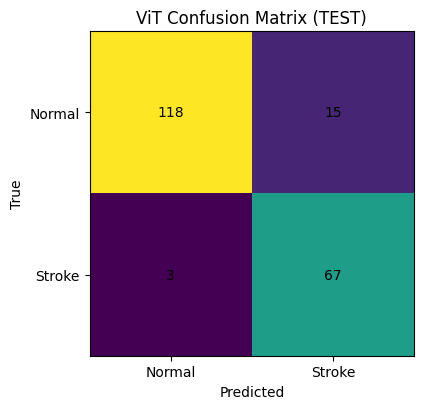

In [ ]:
# ===================== ViT (timm) FAIR protocol: Pool(train+val) + 5Fold + Head/Fine + Thr + Ensemble =====================
!pip -q install --no-cache-dir timm

import os, copy, math, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import timm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)

# ------------------ Config ------------------
SEED = 42
DATA_DIR = "/content/dataset_split_clean"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

MODEL_NAME = "vit_large_patch16_224.augreg_in21k_ft_in1k"  # نفس اللي اشتغل معك قوي
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

KFOLD = 5

# Phase A (Head only)
HEAD_EPOCHS = 2
HEAD_LR = 3e-4

# Phase B (Fine-tune)
FINE_EPOCHS = 10
FINE_LR = 2e-5

WEIGHT_DECAY = 0.05
CLIP_GRAD_NORM = 1.0

# ------------------ Reproducibility ------------------
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# ------------------ Build pooled dataset (train+val) and separate test ------------------
train_folder = ImageFolder(os.path.join(DATA_DIR, "train"))
val_folder   = ImageFolder(os.path.join(DATA_DIR, "val"))
test_folder  = ImageFolder(os.path.join(DATA_DIR, "test"))

classes = train_folder.classes
print("Device:", DEVICE)
print("Classes:", classes)

# Make pooled paths/labels from train + val
pool_samples = train_folder.samples + val_folder.samples  # list of (path, class_idx)
test_samples = test_folder.samples

pool_paths = [p for p, y in pool_samples]
pool_y     = np.array([y for p, y in pool_samples], dtype=int)

test_paths = [p for p, y in test_samples]
test_y     = np.array([y for p, y in test_samples], dtype=int)

print(f"Pool train+val: {len(pool_paths)} | Test: {len(test_paths)}")
print(pd.Series(pool_y).map({0:classes[0],1:classes[1]}).value_counts())

# ------------------ Transforms (strong but fair) ------------------
# Train aug (مثل بروتوكولك)
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# Val/Test (no aug)
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class PathsDataset(Dataset):
    def __init__(self, paths, labels, tfm):
        self.paths = paths
        self.labels = labels
        self.tfm = tfm

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # reuse ImageFolder loader logic
        from PIL import Image
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.tfm(img)
        y = int(self.labels[idx])
        return img, y

# ------------------ Metrics helpers ------------------
def predict_proba(model, loader):
    model.eval()
    probs = []
    ys = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = model(x)
            p = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
            probs.append(p)
            ys.append(y.numpy())
    return np.concatenate(probs), np.concatenate(ys)

def best_thr_by_f1(y_true, proba):
    y_true = np.asarray(y_true).astype(int)
    proba  = np.asarray(proba).ravel()
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2 * prec * rec / (prec + rec + 1e-12)
    f1_thr = f1[1:]  # align with thr
    i = int(np.nanargmax(f1_thr))
    return float(thr[i]), float(f1_thr[i])

def f1_at_thr(y_true, proba, thr):
    y_true = np.asarray(y_true).astype(int)
    pred = (np.asarray(proba).ravel() >= thr).astype(int)
    # manual f1 for positive
    tp = ((pred==1) & (y_true==1)).sum()
    fp = ((pred==1) & (y_true==0)).sum()
    fn = ((pred==0) & (y_true==1)).sum()
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1 = 2*precision*recall/(precision+recall+1e-12)
    return float(f1), float(precision), float(recall)

# ------------------ Model factory ------------------
def make_model(model_name=MODEL_NAME, num_classes=NUM_CLASSES):
    m = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return m

# ------------------ Train epoch ------------------
def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    total_loss = 0.0
    total = 0
    correct = 0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(DEVICE.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        if scaler is not None:
            scaler.scale(loss).backward()
            if CLIP_GRAD_NORM is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if CLIP_GRAD_NORM is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total += x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()

    return total_loss/total, correct/total

# ------------------ Eval metrics ------------------
def eval_metrics(model, loader):
    proba, y = predict_proba(model, loader)
    pr  = average_precision_score(y, proba)
    roc = roc_auc_score(y, proba)
    return float(pr), float(roc), proba, y

# ------------------ KFold training ------------------
skf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=SEED)

fold_rows = []
fold_val_probas = []  # store proba on TEST? (we'll do ensemble on test at end)
fold_models = []

# Dataloaders for TEST (fixed)
test_ds = PathsDataset(test_paths, test_y, eval_tf)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

print("Model:", MODEL_NAME)
use_amp = (DEVICE.type == "cuda")
scaler = torch.amp.GradScaler("cuda", enabled=use_amp) if use_amp else None
print("✅ Mixed precision:", use_amp)

for fold, (tr_idx, va_idx) in enumerate(skf.split(pool_paths, pool_y), start=1):
    print(f"\n================= FOLD {fold}/{KFOLD} =================")

    X_tr = [pool_paths[i] for i in tr_idx]
    y_tr = pool_y[tr_idx]
    X_va = [pool_paths[i] for i in va_idx]
    y_va = pool_y[va_idx]

    # class weights (fair like your runs)
    n0 = (y_tr==0).sum(); n1=(y_tr==1).sum()
    w0 = (len(y_tr)/(2*max(n0,1)))
    w1 = (len(y_tr)/(2*max(n1,1)))
    class_weight = torch.tensor([w0, w1], dtype=torch.float32).to(DEVICE)
    print(f"class_weight: {{0:{w0:.4f}, 1:{w1:.4f}}}")

    tr_ds = PathsDataset(X_tr, y_tr, train_tf)
    va_ds = PathsDataset(X_va, y_va, eval_tf)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))
    va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

    model = make_model().to(DEVICE)

    # -------- Phase A: Head only (freeze backbone) --------
    # timm غالباً classifier اسمه head أو classifier
    # نجمد كل شيء ثم نفك رأس التصنيف فقط
    for p in model.parameters():
        p.requires_grad = False

    # حاول تحديد طبقة الرأس (timm يدعم get_classifier/reset_classifier)
    clf = model.get_classifier()
    # فك رأس التصنيف
    for p in clf.parameters():
        p.requires_grad = True

    criterion = nn.CrossEntropyLoss(weight=class_weight)

    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                            lr=HEAD_LR, weight_decay=WEIGHT_DECAY)

    # تدريب head
    best_state = None
    best_val_pr = -1.0

    for e in range(HEAD_EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, tr_loader, opt, scaler, criterion)
        val_pr, val_roc, _, _ = eval_metrics(model, va_loader)
        print(f"[F{fold}-HEAD] Epoch {e+1}/{HEAD_EPOCHS} | loss={tr_loss:.4f} | val_pr={val_pr:.4f} | val_roc={val_roc:.4f}")
        if val_pr > best_val_pr:
            best_val_pr = val_pr
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # -------- Phase B: Fine-tune (unfreeze all) --------
    for p in model.parameters():
        p.requires_grad = True

    # LRs: low for backbone, a bit higher for head
    # get head params
    head_params = list(model.get_classifier().parameters())
    head_param_ids = set([id(p) for p in head_params])
    backbone_params = [p for p in model.parameters() if id(p) not in head_param_ids]

    opt = torch.optim.AdamW(
        [
            {"params": backbone_params, "lr": FINE_LR},
            {"params": head_params, "lr": FINE_LR*5.0},
        ],
        weight_decay=WEIGHT_DECAY
    )

    # Scheduler بسيط (اختياري)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=FINE_EPOCHS)

    best_state = None
    best_val_f1 = -1.0
    best_thr = 0.5
    best_val_pr = -1.0
    best_val_roc = -1.0

    for e in range(FINE_EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, tr_loader, opt, scaler, criterion)

        val_pr, val_roc, val_proba, val_y_true = eval_metrics(model, va_loader)
        thr, _ = best_thr_by_f1(val_y_true, val_proba)
        val_f1, _, _ = f1_at_thr(val_y_true, val_proba, thr)

        print(f"[F{fold}-FINE] Epoch {e+1}/{FINE_EPOCHS} | loss={tr_loss:.4f} | val_pr={val_pr:.4f} | val_roc={val_roc:.4f}")

        # معيار الحفظ: أعلى F1 على الفولد
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_thr = thr
            best_val_pr = val_pr
            best_val_roc = val_roc
            best_state = copy.deepcopy(model.state_dict())

        sched.step()

    model.load_state_dict(best_state)
    print(f"✅ Fold {fold} | best_thr={best_thr:.4f} | val_f1={best_val_f1:.4f} | val_pr={best_val_pr:.4f} | val_roc={best_val_roc:.4f}")

    fold_rows.append({"fold": fold, "thr": best_thr, "val_f1": best_val_f1, "val_pr": best_val_pr, "val_roc": best_val_roc})

    # store model for ensemble (or store test probas per fold)
    test_proba, _ = predict_proba(model, test_loader)
    fold_val_probas.append(test_proba)

# ------------------ Fold summary ------------------
fold_df = pd.DataFrame(fold_rows)
display(fold_df)

ens_thr = float(np.median(fold_df["thr"].values))
print(f"\n✅ Ensemble threshold (median folds) = {ens_thr:.4f}")

# Ensemble probas on TEST (mean of folds)
ens_proba = np.mean(np.vstack(fold_val_probas), axis=0)

test_roc = roc_auc_score(test_y, ens_proba)
test_pr  = average_precision_score(test_y, ens_proba)

print(f"TEST ROC-AUC: {test_roc:.6f}")
print(f"TEST PR-AUC : {test_pr:.6f}")

ens_pred = (ens_proba >= ens_thr).astype(int)

print("\n=== TEST classification report (Ensemble ViT) ===")
print(classification_report(test_y, ens_pred, target_names=classes, digits=4))

cm = confusion_matrix(test_y, ens_pred)
print("Confusion Matrix:\n", cm)

import matplotlib.pyplot as plt
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm)
plt.title("ViT Confusion Matrix (TEST)")
plt.xticks([0,1], classes, rotation=0)
plt.yticks([0,1], classes, rotation=0)
plt.xlabel("Predicted"); plt.ylabel("True")
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.show()
# ==========================================================================================================================


## Final Comparison: Swin vs ConvNeXt vs ViT

=== 🏆 Final Models Comparison Table ===


,Accuracy,F1-Score (Stroke),ROC-AUC,PR-AUC
Model,,,,
Swin Transformer,0.842400,0.768100,0.918500,0.862900
ConvNeXt,0.822700,0.753400,0.896700,0.850300
ViT (Large),0.911300,0.881600,0.979200,0.965300


<Figure size 1000x600 with 0 Axes>

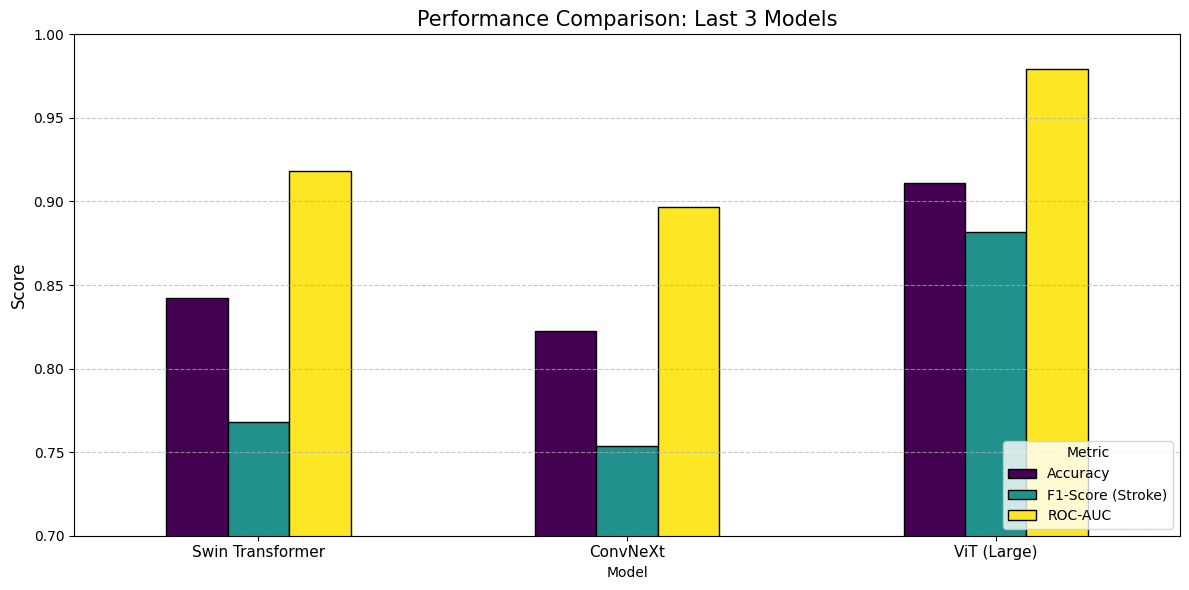

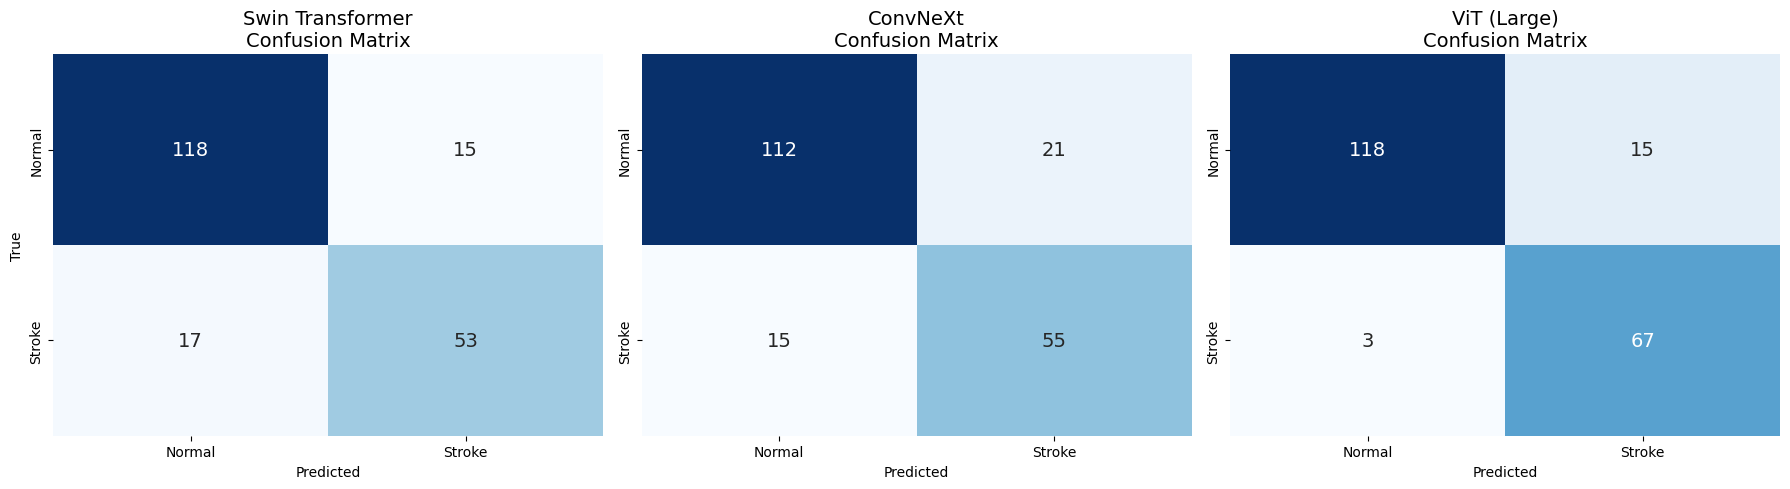

In [ ]:
# ✅ Final Comparison: Swin vs ConvNeXt vs ViT
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Data gathered from previous execution logs (Manual Reconstruction)
models = ["Swin Transformer", "ConvNeXt", "ViT (Large)"]

# Metrics (from logs)
metrics = {
    "Accuracy": [0.8424, 0.8227, 0.9113],
    "F1-Score (Stroke)": [0.7681, 0.7534, 0.8816],
    "ROC-AUC": [0.9185, 0.8967, 0.9792],
    "PR-AUC":  [0.8629, 0.8503, 0.9653]
}

# Confusion Matrices (from logs)
cms = [
    np.array([[118, 15], [17, 53]]),  # Swin
    np.array([[112, 21], [15, 55]]),  # ConvNeXt
    np.array([[118, 15], [3, 67]])    # ViT
]

# 2. DataFrame Comparison
df_comp = pd.DataFrame(metrics, index=models)
df_comp.index.name = "Model"
print("=== 🏆 Final Models Comparison Table ===")
display(df_comp.style.background_gradient(cmap="Blues", axis=0))

# 3. Grouped Bar Chart
plt.figure(figsize=(10, 6))
# Select 3 main metrics to plot as requested
plot_metrics = ["Accuracy", "F1-Score (Stroke)", "ROC-AUC"]
df_plot = df_comp[plot_metrics]

# Plot
df_plot.plot(kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black")
plt.title("Performance Comparison: Last 3 Models", fontsize=15)
plt.ylabel("Score", fontsize=12)
plt.ylim(0.7, 1.0)  # Zoom in to see differences
plt.xticks(rotation=0, fontsize=11)
plt.legend(loc="lower right", title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Confusion Matrices Side-by-Side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
classes = ["Normal", "Stroke"]

for i, (model_name, cm) in enumerate(zip(models, cms)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=classes, yticklabels=classes, ax=axes[i], annot_kws={"size": 14})
    axes[i].set_title(f"{model_name}\nConfusion Matrix", fontsize=14)
    axes[i].set_xlabel("Predicted")
    if i == 0: axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()

## ViT (Large) Grad-CAM Normal+Stroke

### Stroke



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RUN_DIR: /content/drive/MyDrive/ViT_Exports/vit_large_patch16_224.augreg_in21k_ft_in1k_20260102_220726
CKPT  : /content/drive/MyDrive/ViT_Exports/vit_large_patch16_224.augreg_in21k_ft_in1k_20260102_220726/vit_checkpoint.pt
Model: vit_large_patch16_224.augreg_in21k_ft_in1k
Classes: ['Normal', 'Stroke']
Threshold: 0.5556488633155823
Device: cuda

Image: /content/dataset_split_clean/test/Stroke/66 (8).jpg
True folder: Stroke
Probs: {'Normal': 0.019969215616583824, 'Stroke': 0.9800308346748352}
Pred : Stroke (idx=1)


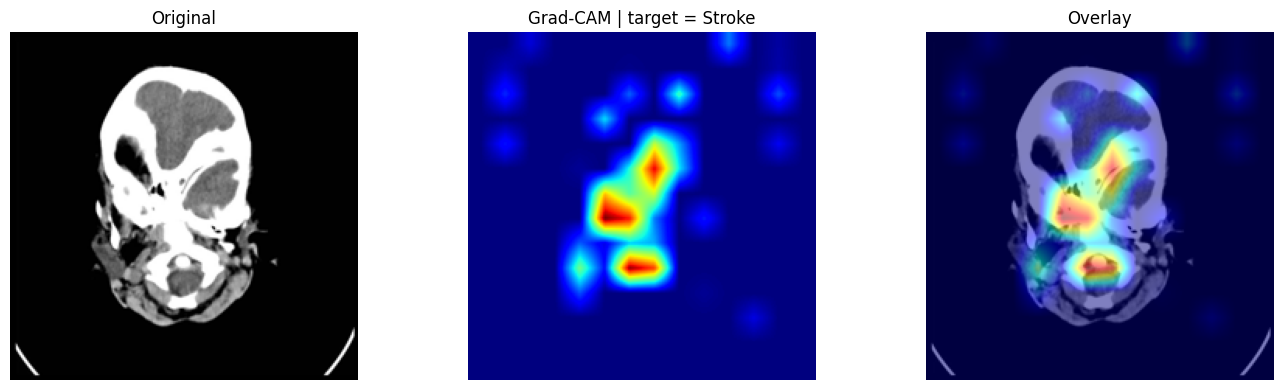

In [ ]:
# ===================== ViT Grad-CAM (SAFE, from SAVED CHECKPOINT) =====================
!pip -q install --no-cache-dir grad-cam

from google.colab import drive
drive.mount("/content/drive")

import os, glob, random
import numpy as np
import torch
import timm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# -------------------------
# 1) Auto-pick latest checkpoint from Drive
# -------------------------
ROOT = "/content/drive/MyDrive/ViT_Exports"
cands = []
for d in glob.glob(os.path.join(ROOT, "*")):
    ckpt = os.path.join(d, "vit_checkpoint.pt")
    if os.path.isfile(ckpt):
        cands.append((d, ckpt, os.path.getmtime(ckpt)))

if len(cands) == 0:
    raise RuntimeError(f"No vit_checkpoint.pt found under: {ROOT}")

cands.sort(key=lambda x: x[2], reverse=True)
RUN_DIR, CKPT_PATH, _ = cands[0]
print("RUN_DIR:", RUN_DIR)
print("CKPT  :", CKPT_PATH)

# -------------------------
# 2) Load checkpoint (PyTorch 2.6 safe)
# -------------------------
try:
    ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=False)
except TypeError:
    ckpt = torch.load(CKPT_PATH, map_location="cpu")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = ckpt["model_name"]
NUM_CLASSES = int(ckpt["num_classes"])
IMG_SIZE = int(ckpt["img_size"])
classes = ckpt.get("classes", ["Normal", "Stroke"])
thr = float(ckpt.get("ensemble_threshold", 0.5))
mean = ckpt["mean"]; std = ckpt["std"]

model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(ckpt["state_dict"], strict=True)
model.eval().to(DEVICE)

print("Model:", MODEL_NAME)
print("Classes:", classes)
print("Threshold:", thr)
print("Device:", DEVICE)

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# -------------------------
# 3) Choose an image (either fixed path or random from test)
# -------------------------
DATA_DIR = "/content/dataset_split_clean"
test_root = os.path.join(DATA_DIR, "test")
exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp")

# OPTION A: set a specific image path
IMAGE_PATH = None  # مثال: "/content/dataset_split_clean/test/Normal/100 (30).jpg"

# OPTION B: random image from test if IMAGE_PATH is None
if IMAGE_PATH is None:
    all_imgs = []
    for cls_name in sorted(os.listdir(test_root)):
        cls_dir = os.path.join(test_root, cls_name)
        if not os.path.isdir(cls_dir):
            continue
        for fn in os.listdir(cls_dir):
            if fn.lower().endswith(exts):
                all_imgs.append((os.path.join(cls_dir, fn), cls_name))
    if len(all_imgs) == 0:
        raise RuntimeError(f"No images found under: {test_root}")
    IMAGE_PATH, true_folder = random.choice(all_imgs)
else:
    true_folder = os.path.basename(os.path.dirname(IMAGE_PATH))

img_pil = Image.open(IMAGE_PATH).convert("RGB")

# -------------------------
# 4) Forward pass to get prediction
# -------------------------
x = tfm(img_pil).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    logits = model(x)
    prob = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()

pred_idx = int(np.argmax(prob))
pred_name = classes[pred_idx]
p1 = float(prob[1]) if len(prob) > 1 else float(prob[pred_idx])

print("\nImage:", IMAGE_PATH)
print("True folder:", true_folder)
print("Probs:", {classes[i]: float(prob[i]) for i in range(len(classes))})
print("Pred :", pred_name, f"(idx={pred_idx})")

# -------------------------
# 5) Target choice (IMPORTANT)
#     - Default: target = predicted class (recommended)
#     - If you want to FORCE Stroke target: set FORCE_TARGET = 1
# -------------------------
FORCE_TARGET = None  # None = predicted | 1 = Stroke | 0 = Normal

target_class = pred_idx if FORCE_TARGET is None else int(FORCE_TARGET)
targets = [ClassifierOutputTarget(target_class)]

# -------------------------
# 6) ViT reshape_transform + target layer
# -------------------------
patch = model.patch_embed.patch_size[0] if isinstance(model.patch_embed.patch_size, tuple) else model.patch_embed.patch_size
grid_size = IMG_SIZE // patch

def reshape_transform(tensor):
    # [B, tokens, C] -> drop CLS -> [B, H, W, C] -> [B, C, H, W]
    tensor = tensor[:, 1:, :]
    tensor = tensor.reshape(tensor.size(0), grid_size, grid_size, tensor.size(2))
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

target_layers = [model.blocks[-1].norm1]  # correct for THIS model

# -------------------------
# 7) Grad-CAM
# -------------------------
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
grayscale_cam = cam(input_tensor=x, targets=targets)[0]
grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-12)

# overlay image must be RGB in [0,1]
img_disp = img_pil.resize((IMG_SIZE, IMG_SIZE))
rgb_img = np.array(img_disp).astype(np.float32) / 255.0
overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# -------------------------
# 8) Plot
# -------------------------
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(rgb_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(grayscale_cam, cmap="jet")
plt.title(f"Grad-CAM | target = {classes[target_class]}")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


### Normal



⚠️ لم أجد checkpoints للفولدات على القرص.
➡️ سأستخدم آخر نموذج موجود في المتغير model فقط (Grad-CAM Single Model).


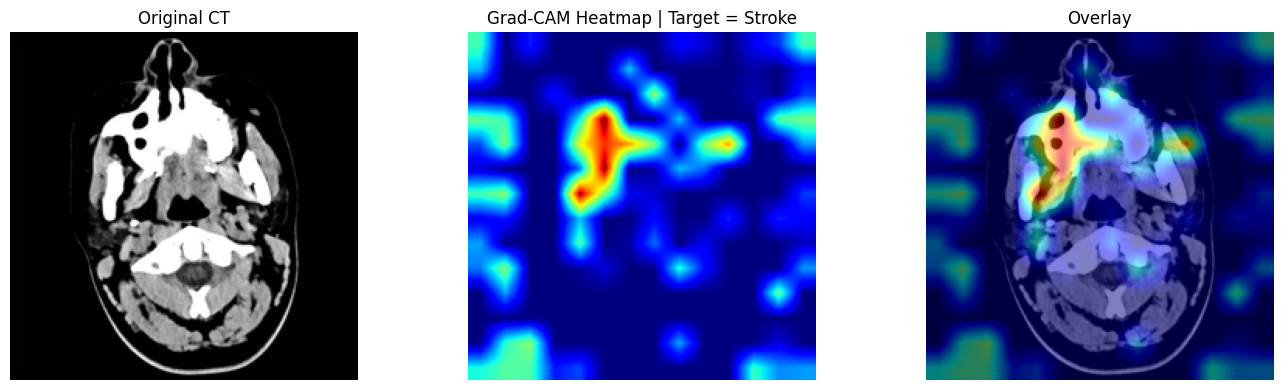

Image: /content/dataset_split_clean/test/Normal/100 (1).jpg
Target class = 1 (Stroke)
Models used = 1
Model 1: Pred=Normal | P(pred)=1.000 | P(target)=0.000


In [ ]:
# ===================== Ensemble/Single Grad-CAM for ViT (timm) AFTER training  =====================
!pip -q install --no-cache-dir grad-cam

import os, glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# -------------------------
# 0) Checks (from training cell)
# -------------------------
assert "MODEL_NAME" in globals()
assert "IMG_SIZE" in globals()
assert "DEVICE" in globals()
assert "eval_tf" in globals()
assert "test_paths" in globals() and len(test_paths) > 0
assert "classes" in globals()
assert "make_model" in globals()

# -------------------------
# 1) Load fold checkpoints if exist, else fallback to last `model`
# -------------------------
SEARCH_DIRS = ["/content/vit_folds_saved", "/content"]
ckpt_paths = []
for d in SEARCH_DIRS:
    ckpt_paths += sorted(glob.glob(os.path.join(d, "vit_fold*_best.pth")))
ckpt_paths = sorted(list(set(ckpt_paths)))

fold_models_loaded = []
if len(ckpt_paths) > 0:
    print(f"✅ Found {len(ckpt_paths)} fold checkpoints:")
    for p in ckpt_paths:
        print(" -", p)

    for pth in ckpt_paths:
        m = make_model().to(DEVICE)
        state = torch.load(pth, map_location="cpu")
        m.load_state_dict(state, strict=True)
        m.eval()
        fold_models_loaded.append(m)

    print(f"✅ Loaded fold models: {len(fold_models_loaded)}")
else:
    print("⚠️ لم أجد checkpoints للفولدات على القرص.")
    print("➡️ سأستخدم آخر نموذج موجود في المتغير model فقط (Grad-CAM Single Model).")
    assert "model" in globals(), "لا يوجد model في الذاكرة. شغّل خلية التدريب أولاً."
    fold_models_loaded = [model.to(DEVICE).eval()]

# -------------------------
# 2) ViT reshape_transform for token->(C,H,W)
# -------------------------
vit_any = fold_models_loaded[0]
patch = vit_any.patch_embed.patch_size
if isinstance(patch, tuple):
    patch = patch[0]
grid_size = IMG_SIZE // patch

def reshape_transform(tensor):
    # [B, tokens, C] -> remove CLS -> [B, H, W, C] -> [B, C, H, W]
    tensor = tensor[:, 1:, :]
    tensor = tensor.reshape(tensor.size(0), grid_size, grid_size, tensor.size(2))
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

target_layers = [vit_any.blocks[-1].norm1]

# -------------------------
# 3) Pick a TEST image
# -------------------------
idx = 0  # يمكننا تغيير الرقم  حسب نوع الصورة المطلوب
img_path = test_paths[idx]

img_pil = Image.open(img_path).convert("RGB")
img_disp = img_pil.resize((IMG_SIZE, IMG_SIZE))
rgb_img = np.array(img_disp).astype(np.float32) / 255.0

x = eval_tf(img_pil).unsqueeze(0).to(DEVICE)

# target class (Stroke=1) — عدّل إذا لزم
target_class = 1
targets = [ClassifierOutputTarget(target_class)]

# -------------------------
# 4) Grad-CAM per model + Ensemble average
#    IMPORTANT: no `use_cuda` parameter (fixed)
# -------------------------
all_cams = []
preds_info = []

for i, m in enumerate(fold_models_loaded, start=1):
    cam = None
    try:
        cam = GradCAM(
            model=m,
            target_layers=target_layers,
            reshape_transform=reshape_transform
        )

        grayscale_cam = cam(input_tensor=x, targets=targets)[0]  # [H,W]
        all_cams.append(grayscale_cam)

        with torch.no_grad():
            logits = m(x)
            prob = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
            pred = int(np.argmax(prob))
            preds_info.append((pred, float(prob[pred]), float(prob[target_class])))

    finally:
        # avoid hook-related warnings
        if cam is not None and hasattr(cam, "activations_and_grads"):
            cam.activations_and_grads.release()

# Ensemble CAM
ens_cam = np.mean(np.stack(all_cams, axis=0), axis=0)
ens_cam = (ens_cam - ens_cam.min()) / (ens_cam.max() - ens_cam.min() + 1e-12)

overlay = show_cam_on_image(rgb_img, ens_cam, use_rgb=True)

# -------------------------
# 5) Plot
# -------------------------
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(rgb_img)
plt.title("Original CT")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(ens_cam, cmap="jet")
plt.title(f"Grad-CAM Heatmap | Target = {classes[target_class]}")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Image:", img_path)
print(f"Target class = {target_class} ({classes[target_class]})")
print(f"Models used = {len(fold_models_loaded)}")

for k, (pred, p_pred, p_target) in enumerate(preds_info, start=1):
    print(f"Model {k}: Pred={classes[pred]} | P(pred)={p_pred:.3f} | P(target)={p_target:.3f}")


## ViT (CPU – BSc ACCEPTABLE VERSION)

In [ ]:
# ===================== ViT (CPU – BSc ACCEPTABLE VERSION) =====================
!pip -q install --no-cache-dir timm

import os, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import timm
from sklearn.metrics import classification_report
from collections import Counter

# ------------------ CONFIG ------------------
SEED = 42
DATA_DIR = "/content/dataset_split_clean"
DEVICE = torch.device("cpu")

MODEL_NAME = "vit_base_patch16_224"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 4
MAX_SAMPLES = 200   # توازن جيد بين السرعة والجودة

random.seed(SEED)
torch.manual_seed(SEED)

# ------------------ Transforms ------------------
tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ------------------ Dataset ------------------
full_ds = ImageFolder(os.path.join(DATA_DIR, "train"), transform=tf)

indices = list(range(len(full_ds)))
random.shuffle(indices)
indices = indices[:MAX_SAMPLES]

ds = Subset(full_ds, indices)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

labels = [full_ds.targets[i] for i in indices]
counts = Counter(labels)

w0 = len(labels) / (2 * counts[0])
w1 = len(labels) / (2 * counts[1])
class_weights = torch.tensor([w0, w1], dtype=torch.float32)

print(f"🚀 Samples: {len(ds)} | class_weights={class_weights.tolist()}")

# ------------------ Model ------------------
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=2).to(DEVICE)

# 1) Freeze everything
for p in model.parameters():
    p.requires_grad = False

# 2) Unfreeze classifier
for p in model.get_classifier().parameters():
    p.requires_grad = True

# 3) Unfreeze LAST transformer block فقط
last_block = model.blocks[-1]
for p in last_block.parameters():
    p.requires_grad = True

# ------------------ Optimizer & Loss ------------------
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(
    [
        {"params": model.get_classifier().parameters(), "lr": 3e-4},
        {"params": last_block.parameters(), "lr": 1e-4},
    ],
    weight_decay=1e-4
)

# ------------------ Training ------------------
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} | loss={total_loss/len(loader):.4f}")

print("✅ Training finished (BSc-level ViT)")

# ------------------ Evaluation ------------------
model.eval()
preds, gts = [], []

with torch.no_grad():
    for x, y in loader:
        out = model(x).argmax(1)
        preds.extend(out.numpy())
        gts.extend(y.numpy())

print("\n=== FINAL DEMO CLASSIFICATION REPORT ===")
print(classification_report(gts, preds, target_names=full_ds.classes))


🚀 Samples: 200 | class_weights=[0.7692307829856873, 1.4285714626312256]
Epoch 1/4 | loss=0.7851
Epoch 2/4 | loss=0.4961
Epoch 3/4 | loss=0.3874
Epoch 4/4 | loss=0.2952
✅ Training finished (BSc-level ViT)

=== FINAL DEMO CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       130
      Stroke       0.97      0.91      0.94        70

    accuracy                           0.96       200
   macro avg       0.96      0.95      0.96       200
weighted avg       0.96      0.96      0.96       200



###Grad-CAM (Random Stroke Image | SINGLE MODEL)

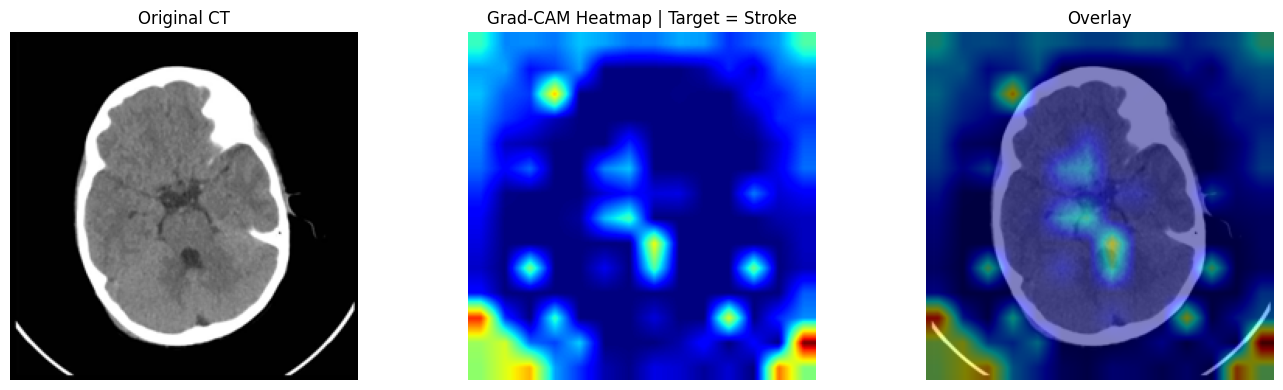

Image: /content/dataset_split_clean/test/Stroke/90 (11).jpg
Target class = Stroke
Prediction = Normal | P(pred)=0.682 | P(Stroke)=0.318


In [ ]:
# ===================== Grad-CAM (Random Stroke Image | SINGLE MODEL) =====================
import os, random
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# -------------------------
# 1) تأكيد وجود model
# -------------------------
assert "model" in globals(), "❌ لا يوجد model في الذاكرة. شغّل خلية التدريب أولاً."

model.eval()

# -------------------------
# 2) اختيار صورة Stroke عشوائية
# -------------------------
stroke_test_paths = [
    p for p in test_paths
    if os.path.basename(os.path.dirname(p)).lower() == "stroke"
]

assert len(stroke_test_paths) > 0, "❌ لا توجد صور Stroke في test set"

img_path = random.choice(stroke_test_paths)

# -------------------------
# 3) تحميل الصورة
# -------------------------
img_pil = Image.open(img_path).convert("RGB")
img_disp = img_pil.resize((IMG_SIZE, IMG_SIZE))
rgb_img = np.array(img_disp).astype(np.float32) / 255.0

x = eval_tf(img_pil).unsqueeze(0).to(DEVICE)

# -------------------------
# 4) إعداد Grad-CAM لـ ViT
# -------------------------
target_class = classes.index("Stroke")
targets = [ClassifierOutputTarget(target_class)]

patch = model.patch_embed.patch_size
patch = patch[0] if isinstance(patch, tuple) else patch
grid_size = IMG_SIZE // patch

def reshape_transform(tensor):
    tensor = tensor[:, 1:, :]   # إزالة CLS token
    tensor = tensor.reshape(tensor.size(0), grid_size, grid_size, tensor.size(2))
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

target_layers = [model.blocks[-1].norm1]

cam = GradCAM(
    model=model,
    target_layers=target_layers,
    reshape_transform=reshape_transform
)

# -------------------------
# 5) حساب Grad-CAM
# -------------------------
grayscale_cam = cam(input_tensor=x, targets=targets)[0]
grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# تنبؤ النموذج
with torch.no_grad():
    logits = model(x)
    prob = torch.softmax(logits, dim=1)[0].cpu().numpy()
    pred = int(np.argmax(prob))

# -------------------------
# 6) العرض (3 صور دائمًا)
# -------------------------
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original CT")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(grayscale_cam, cmap="jet")
plt.title("Grad-CAM Heatmap | Target = Stroke")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Image:", img_path)
print("Target class = Stroke")
print(f"Prediction = {classes[pred]} | P(pred)={prob[pred]:.3f} | P(Stroke)={prob[target_class]:.3f}")
